In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
%run function.ipynb

sns.color_palette()

np.set_printoptions(suppress=False)

In [2]:
df = pd.read_csv('clean4.csv')
df_copy = df.copy()
print(df_copy.shape)
df_copy.head(3)

(899153, 45)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,ApprovalDate,Term,NoEmp,...,Population,PopDensity,HousingUnits,OccupiedHousingUnits,MedianHomeValue,MedianHouseholdIncome,USDPerJobCreated,DisbursePerEmployee,GrSBA_AppvDiff%,State_division
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,1997-02-28,84.0,4.0,...,31457.0,1939.0,14267.0,12895.0,115600.0,48618.0,60000.0,12000.000000,20.0,Mid-West
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1997-02-28,60.0,2.0,...,30671.0,457.0,11847.0,10938.0,120200.0,47863.0,40000.0,13333.333333,20.0,Mid-West
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,1997-02-28,180.0,7.0,...,41011.0,495.0,19124.0,17562.0,207900.0,45415.0,287000.0,35875.000000,25.0,Mid-West


In [3]:
# no employee but retain some jobs
df_emp_weird = df_copy[((df_copy['NoEmp'] == 0) & (df_copy['RetainedJob'] != 0)) | ((df_copy['NoEmp'] + df_copy['CreateJob']) < df_copy['RetainedJob'])]
df_copy.drop(list(df_emp_weird.index), axis=0, inplace=True)
print(df_emp_weird.shape)

# weird data create so many job(8800)
df_job_weird = df_copy[(df_copy['CreateJob'] == 8800)| (df_copy['RetainedJob'] == 8800) & (df_copy['NoEmp'] < 500)].sort_values(by=['CreateJob', 'DisbursementDate_year'], ascending=False)
# delete weird data
df_copy = df_copy.drop(list(df_job_weird.index), axis=0)
print(df_job_weird.shape)

(4056, 45)
(646, 45)


In [4]:
obj_features = ['State', 'BankState', 'NewExist', 'IsFranchised', 'UrbanRural', 'RevLineCr', 'LowDoc', 'Industry',
            'ApprovalDate_year', 'ApprovalDate_month', 'DisbursementDate_year', 'DisbursementDate_month', 'State_division']
num_features = ['Default', 'ChgOffPrinGr', 'Term', 'DisbursementGross', 'GrSBA_AppvDiff%', 'DisbursePerEmployee',
                'USDPerJobCreated','NoEmp', 'CreateJob', 'RetainedJob', 'Population', 'PopDensity', 'GrAppv', 'SBA_Appv',
                'HousingUnits', 'OccupiedHousingUnits', 'MedianHomeValue', 'MedianHouseholdIncome']
time_cols = ['ApprovalDate_year', 'ApprovalDate_month', 'DisbursementDate_year', 'DisbursementDate_month']

In [5]:
df_groupby_mean = dict()
df_groupby_size = dict()

for col in obj_features:
    df_groupby_mean[col] = df_copy.groupby(by=col).mean()[num_features]
    df_groupby_size[col] = pd.DataFrame(df_copy.groupby(by=col).size())
    df_groupby_size[col].rename(columns={0: 'size'}, inplace=True)

# LowDoc延伸分析

In [6]:
data = df_copy.groupby(by=['DisbursementDate_year', 'LowDoc']).mean()
data_long = data.melt(ignore_index=False).reset_index()
data_def = data_long[data_long['variable'] == 'Default']

data_def = data_def[data_def['DisbursementDate_year'] >= 1972]
data_def[['DisbursementDate_year', 'LowDoc']] = data_def[['DisbursementDate_year', 'LowDoc']].applymap(lambda x: int(x))
data_def.head(3)

,DisbursementDate_year,LowDoc,variable,value
1037,1972,0,Default,0.971429
1038,1973,0,Default,0.977778
1039,1974,0,Default,1.000000


In [7]:
year_list = list(df_groupby_mean['ApprovalDate_year'][~(df_copy.groupby(by='ApprovalDate_year').size().values < 30)].index)

In [8]:
data = pd.DataFrame(df_copy.groupby(by=['DisbursementDate_year', 'LowDoc']).size()).reset_index()
data.rename(columns={0: 'count'}, inplace=True)
data = data[data['DisbursementDate_year'] >= 1972]
data[['DisbursementDate_year', 'LowDoc']] = data[['DisbursementDate_year', 'LowDoc']].applymap(lambda x: int(x))
data.head(3)

,DisbursementDate_year,LowDoc,count
5,1972,0,35
6,1973,0,45
7,1974,0,35


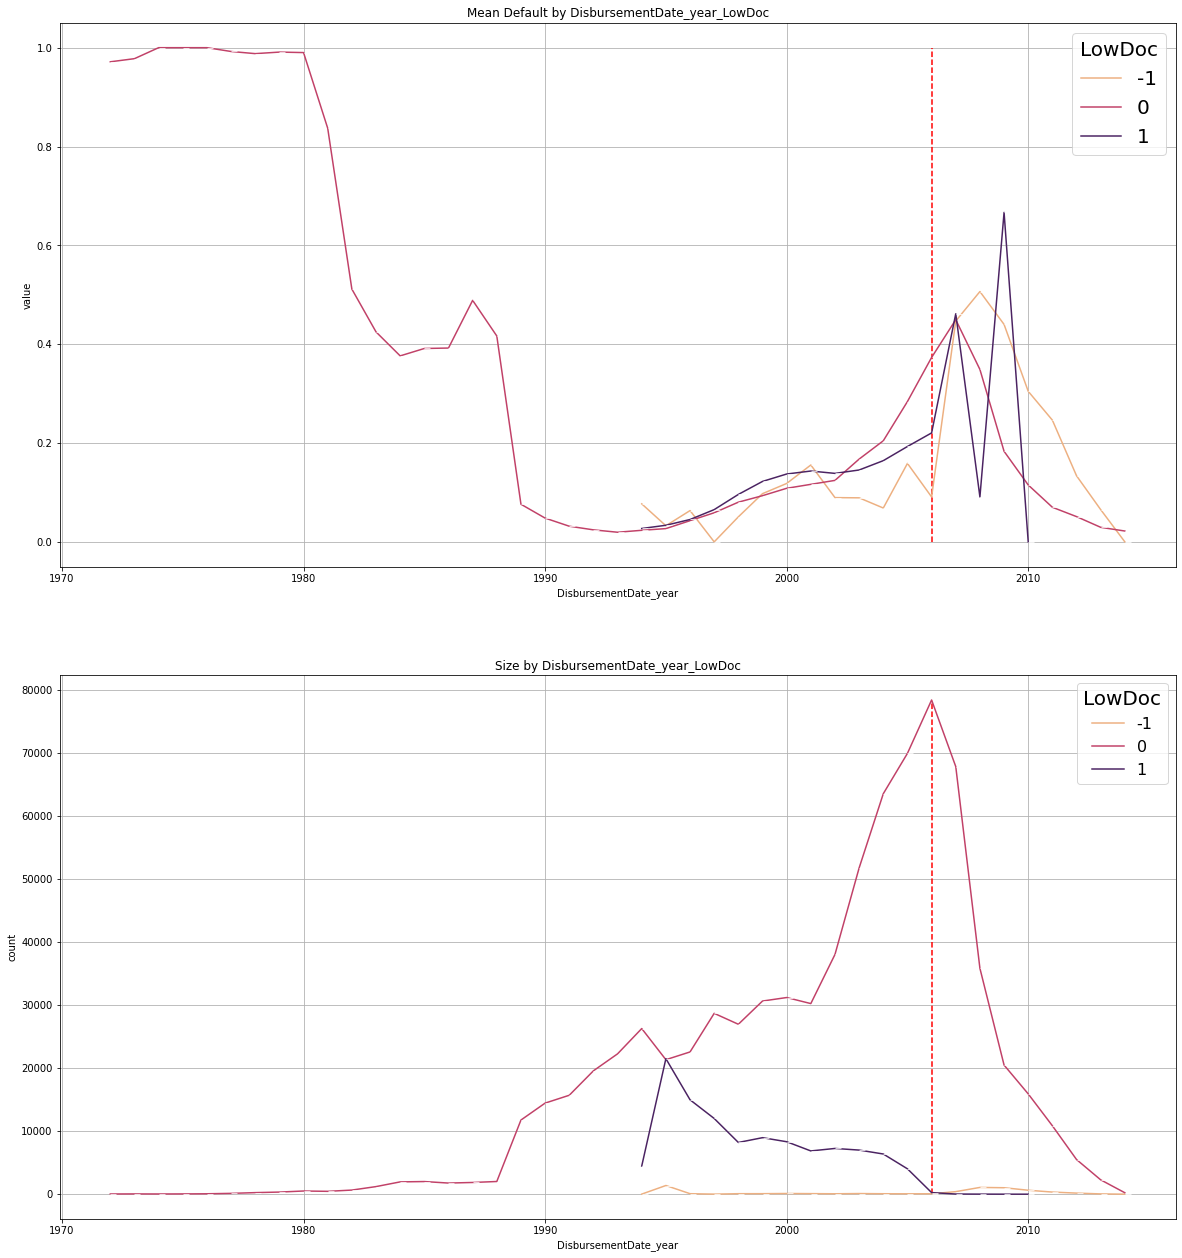

In [9]:
plt.figure(figsize=(20,22))

num = 'Default'

plt.subplot(2, 1, 1)
plt.title('Mean {} by DisbursementDate_year_LowDoc'.format(num))
plt.grid(True)
plt.vlines(x=[2006.0], ymin=data_def['value'].min(), ymax=data_def['value'].max(), color='r', linestyles='dashed')
sns.lineplot(data=data_def, x=data_def['DisbursementDate_year'], y=data_def['value'], marker=True, hue='LowDoc',
             palette="flare")
plt.legend(title='LowDoc', fontsize=20, title_fontsize=20)

plt.subplot(2, 1, 2)
plt.title('Size by DisbursementDate_year_LowDoc'.format(num))
plt.grid(True)
plt.vlines(x=[2006.0], ymin=data['count'].min(), ymax=data['count'].max(), color='r', linestyles='dashed')
sns.lineplot(data=data, x=data['DisbursementDate_year'], y=data['count'], marker=True, hue='LowDoc',
             palette="flare")
plt.legend(title='LowDoc', fontsize=16, title_fontsize=20)

plt.show()

In [10]:
# plt.figure(figsize=(20, 10))

# num = 'Default'

# plt.title('Mean {} by DisbursementDate_year_LowDoc'.format(num))
# plt.grid(True)
# plt.vlines(x=[2006.0], ymin=data_def['value'].min(), ymax=data_def['value'].max(), color='r', linestyles='dashed')
# sns.lineplot(data=data_def, x=data_def['DisbursementDate_year'], y=data_def['value'], marker=True, hue='LowDoc',
#              palette="flare")
# plt.legend(title='LowDoc', fontsize=20, title_fontsize=20)
# plt.savefig('Mean {} by DisbursementDate_year_LowDoc.jpeg'.format(num))
# plt.show()

In [11]:
# plt.figure(figsize=(20, 10))

# plt.title('Size by DisbursementDate_year_LowDoc'.format(num))
# plt.grid(True)
# plt.vlines(x=[2006.0], ymin=data['count'].min(), ymax=data['count'].max(), color='r', linestyles='dashed')
# sns.lineplot(data=data, x=data['DisbursementDate_year'], y=data['count'], marker=True, hue='LowDoc',
#              palette="flare")
# plt.legend(title='LowDoc', fontsize=20, title_fontsize=20)
# plt.savefig('Size by DisbursementDate_year_LowDoc.jpeg')
# plt.show()

In [12]:
# steep decrease of LowDoc Loan between 05' and 06'
data[(data['DisbursementDate_year'] >= 2003) & (data['LowDoc'] == 1)]

,DisbursementDate_year,LowDoc,count
56,2003,1,7000
59,2004,1,6378
62,2005,1,4026
65,2006,1,254
68,2007,1,26
71,2008,1,11
74,2009,1,3
77,2010,1,1


# NoEmp為0的公司

comparison between NoEmp == 0 and the other

In [13]:
%run function.ipynb

In [14]:
df_emp0 = df_copy[(df_copy['NoEmp'] == 0)]

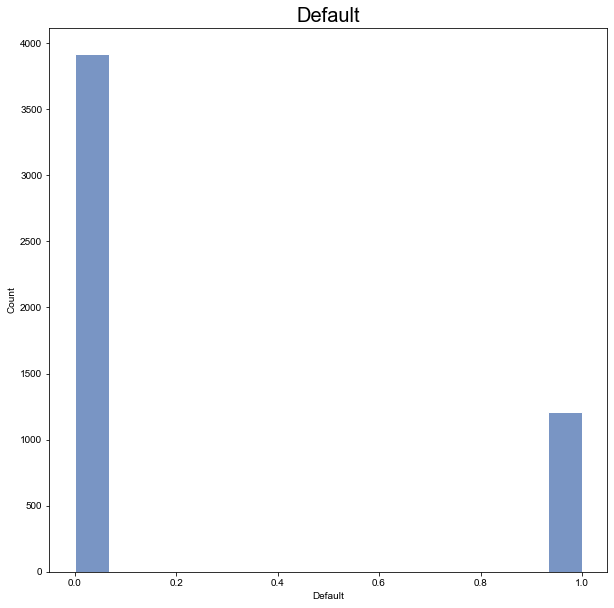

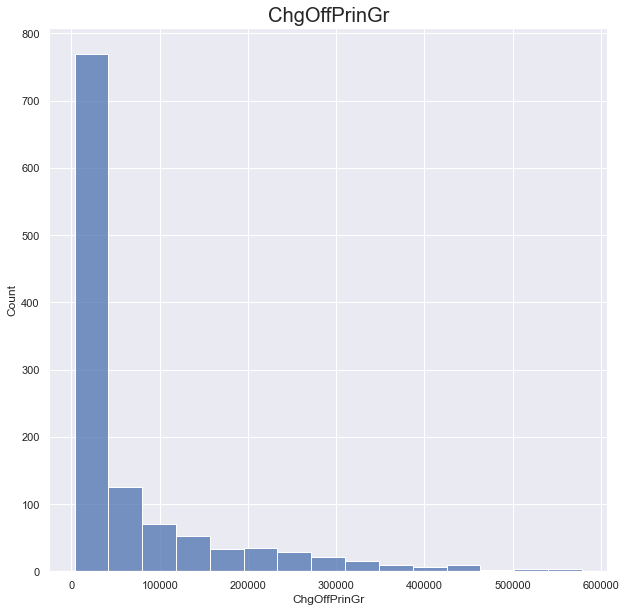

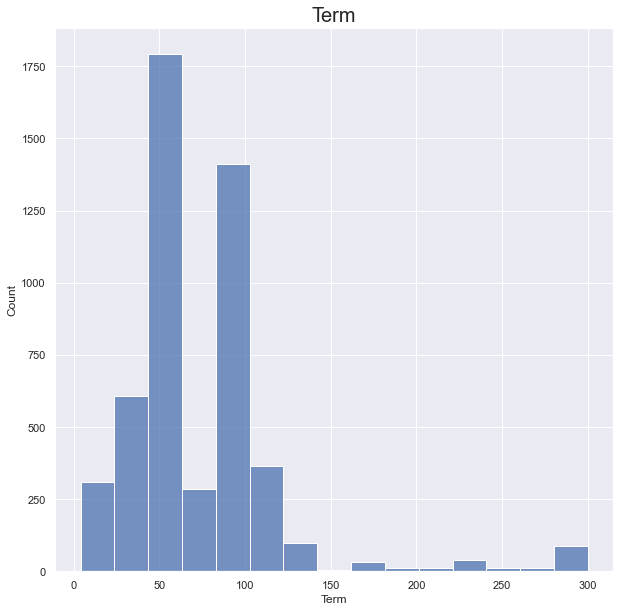

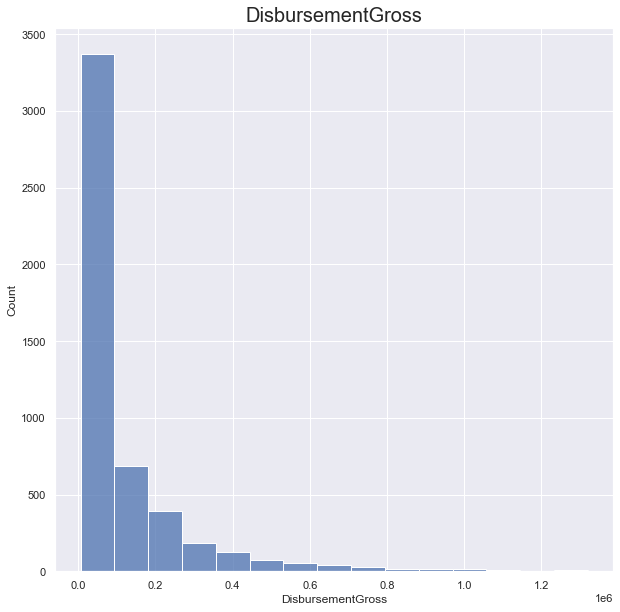

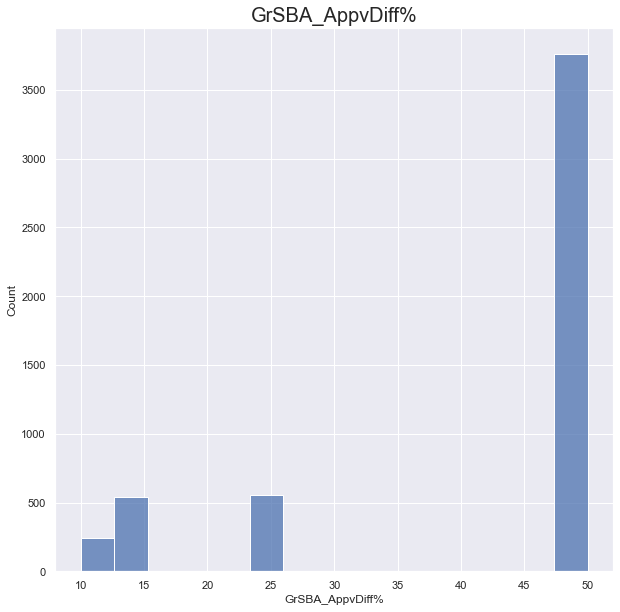

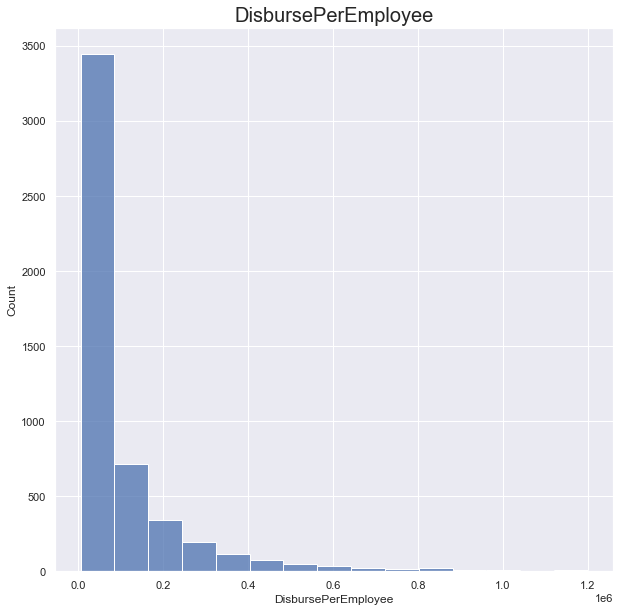

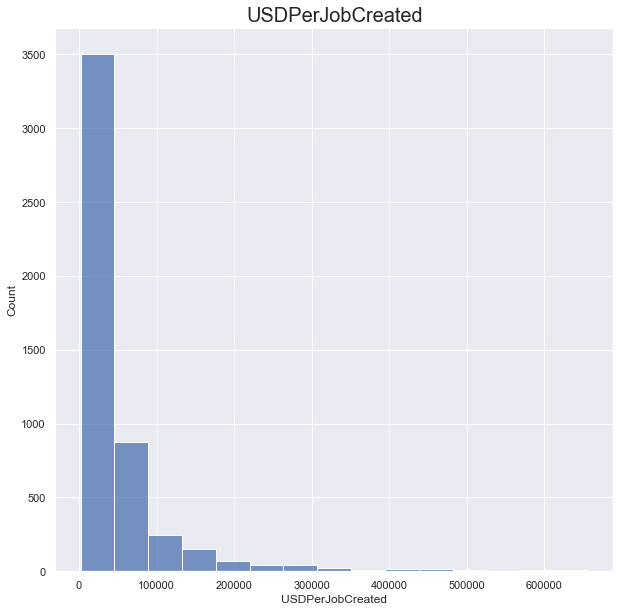

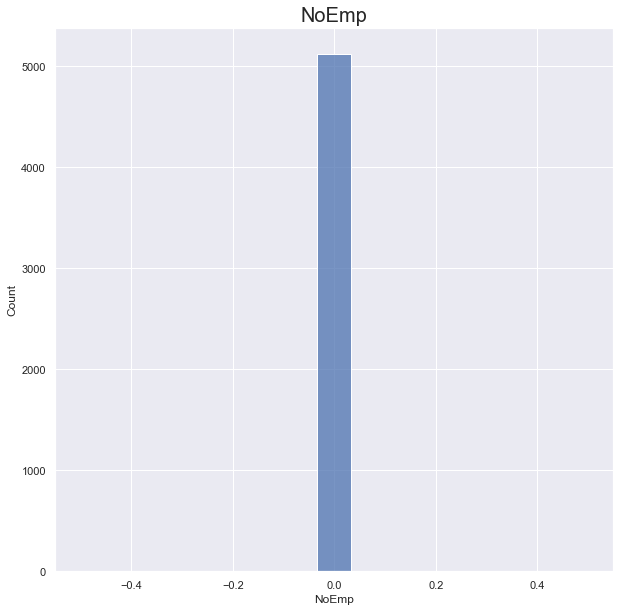

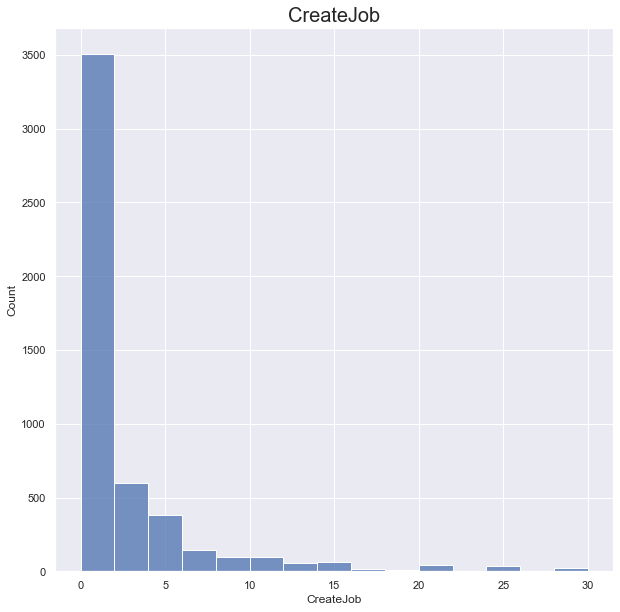

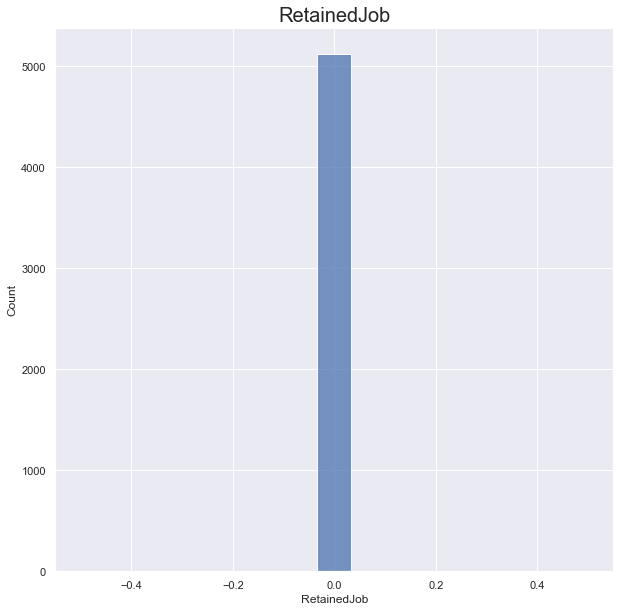

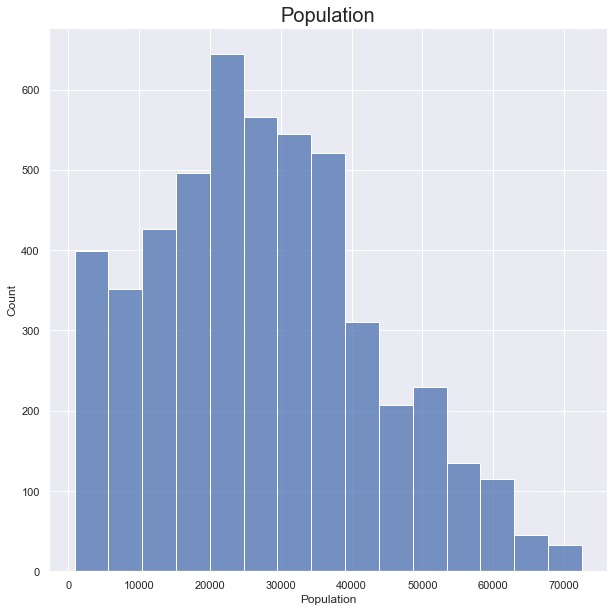

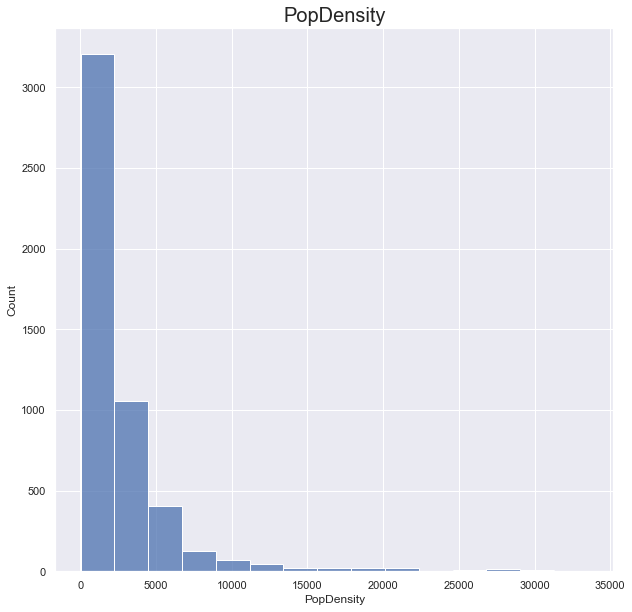

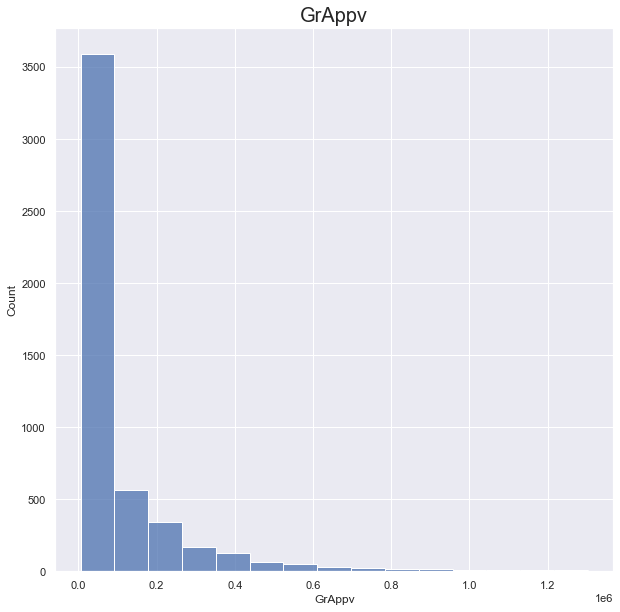

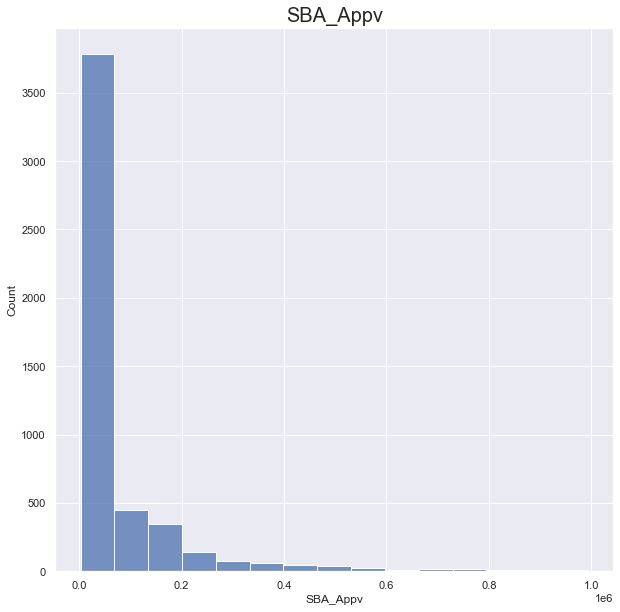

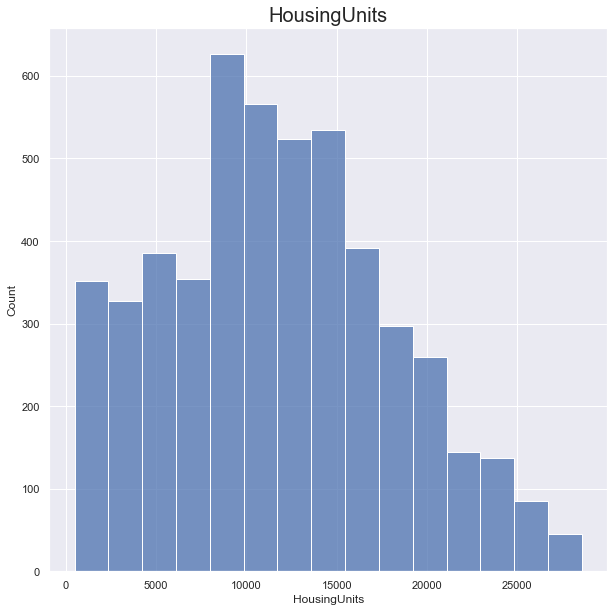

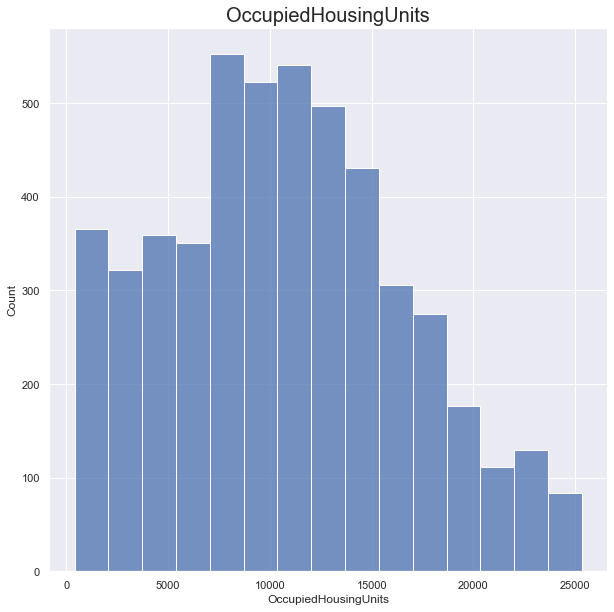

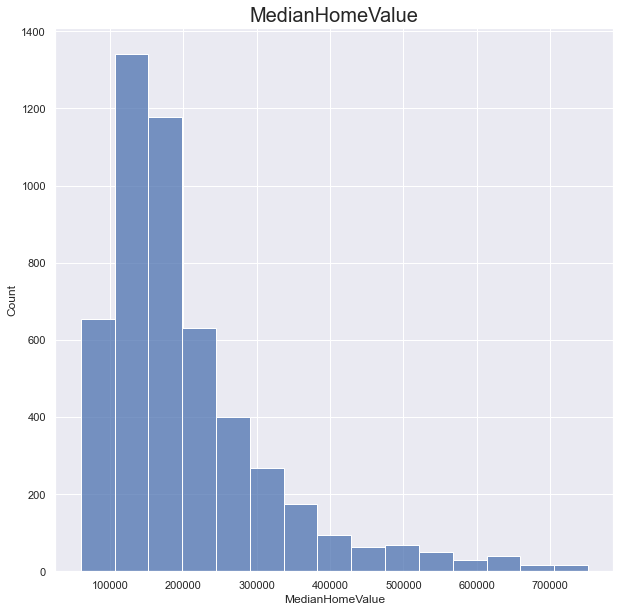

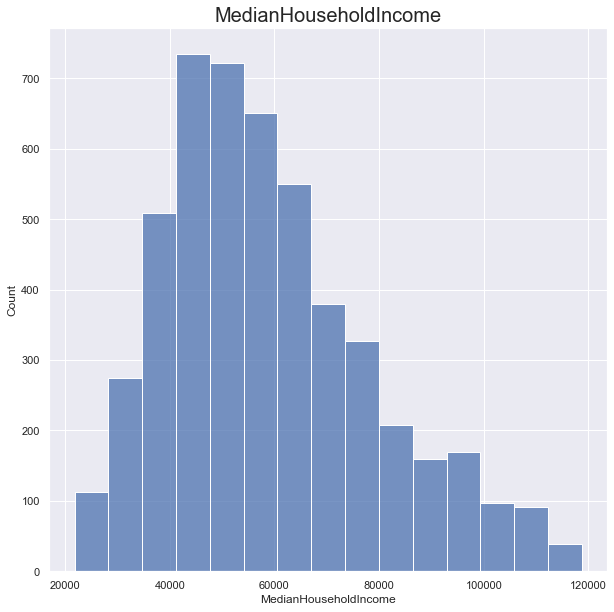

In [15]:
num_visualization(df_emp0, num_features)

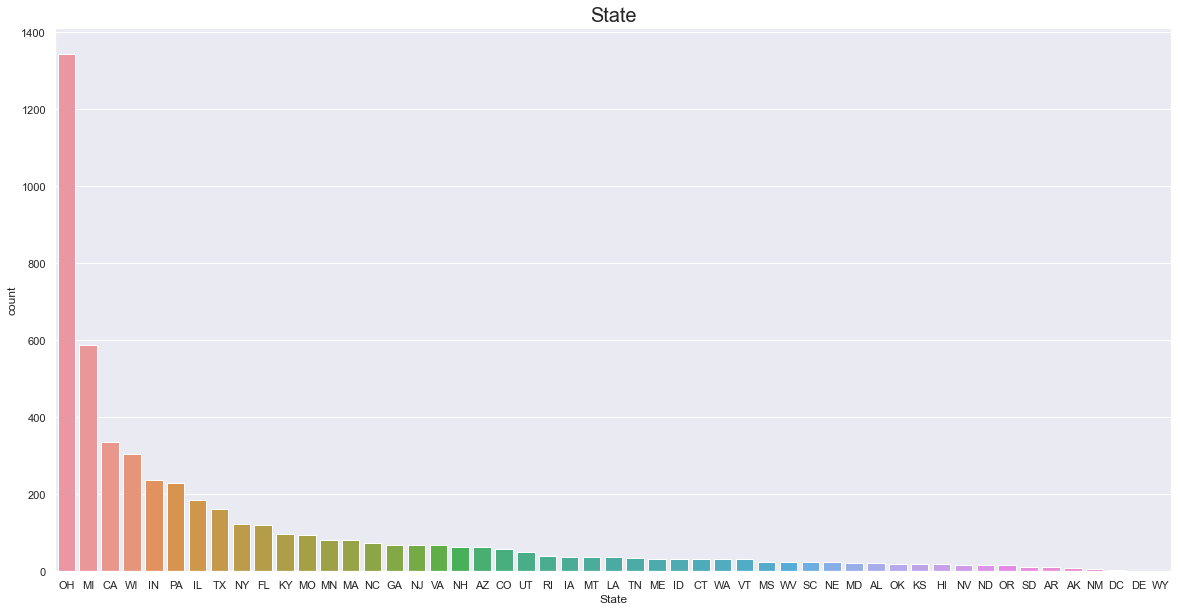

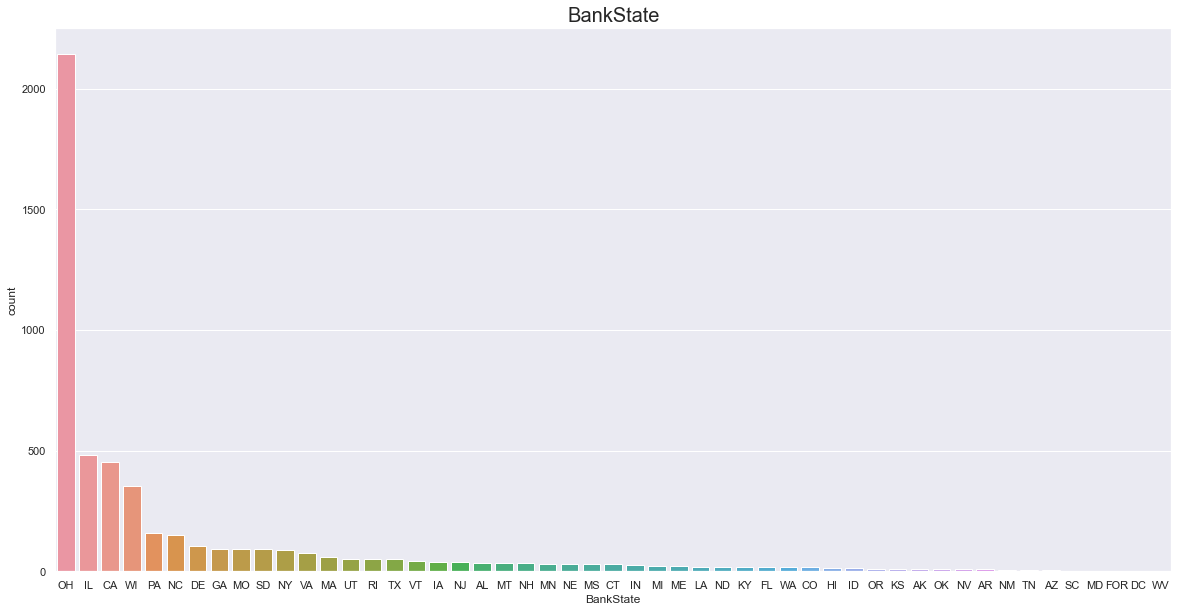

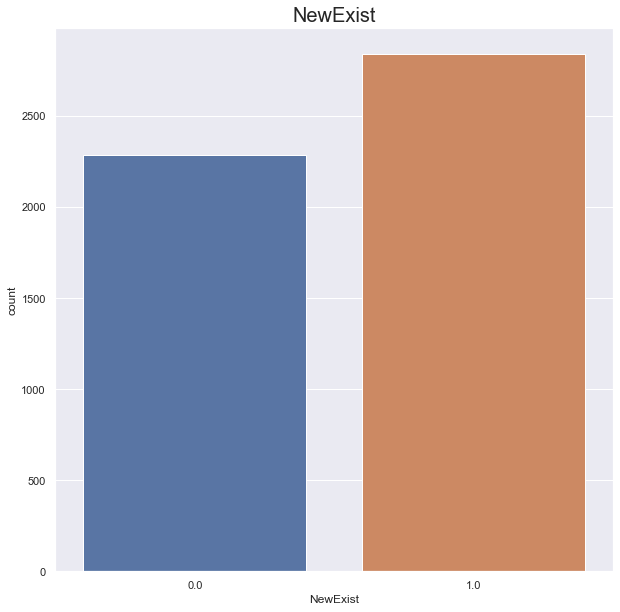

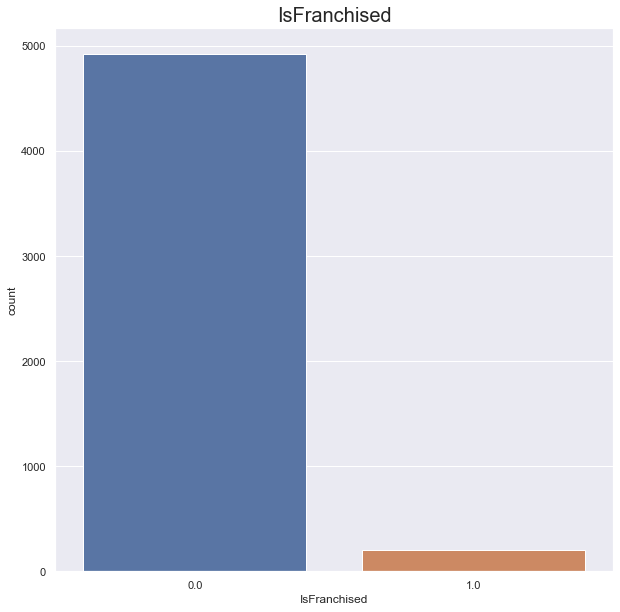

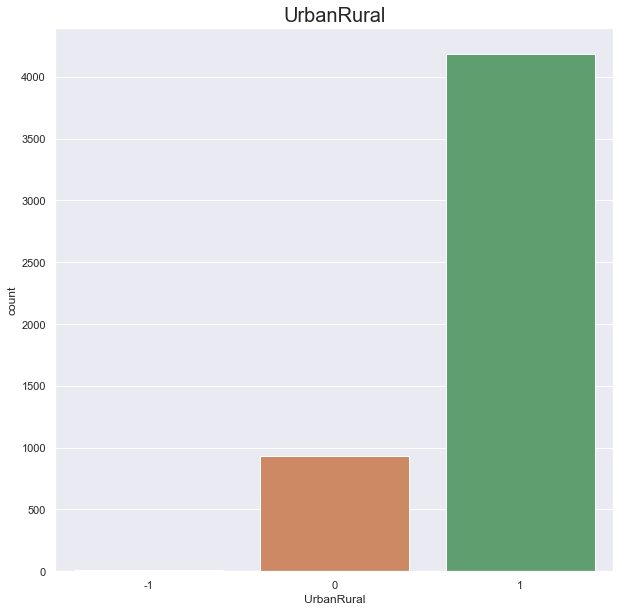

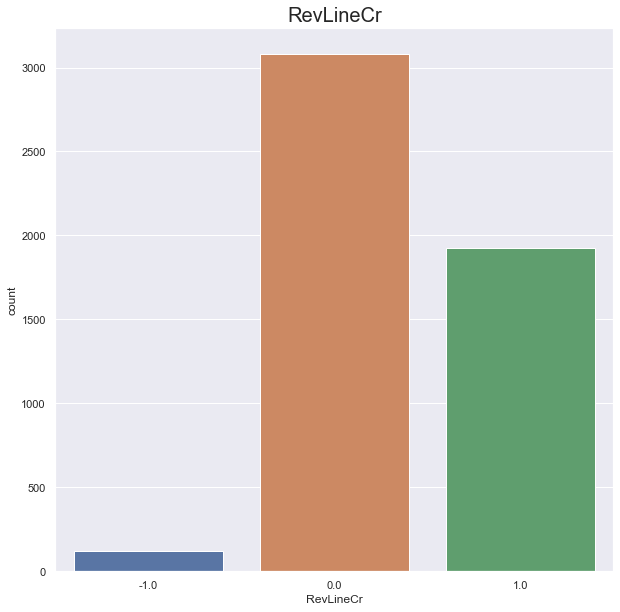

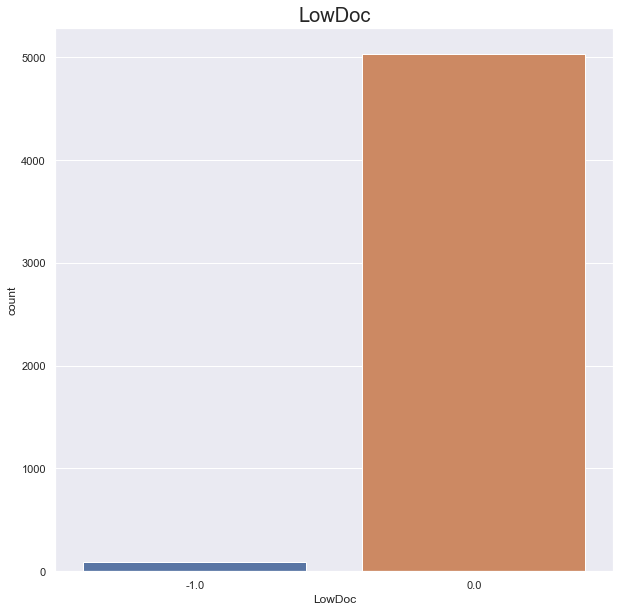

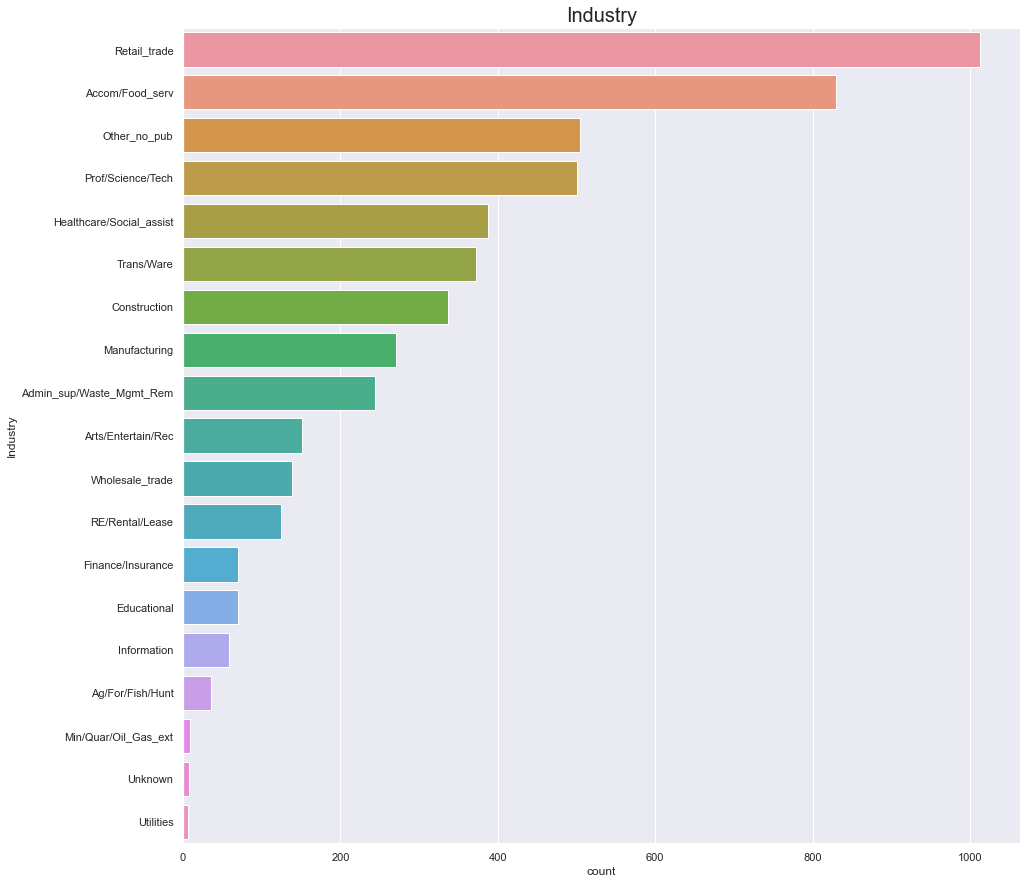

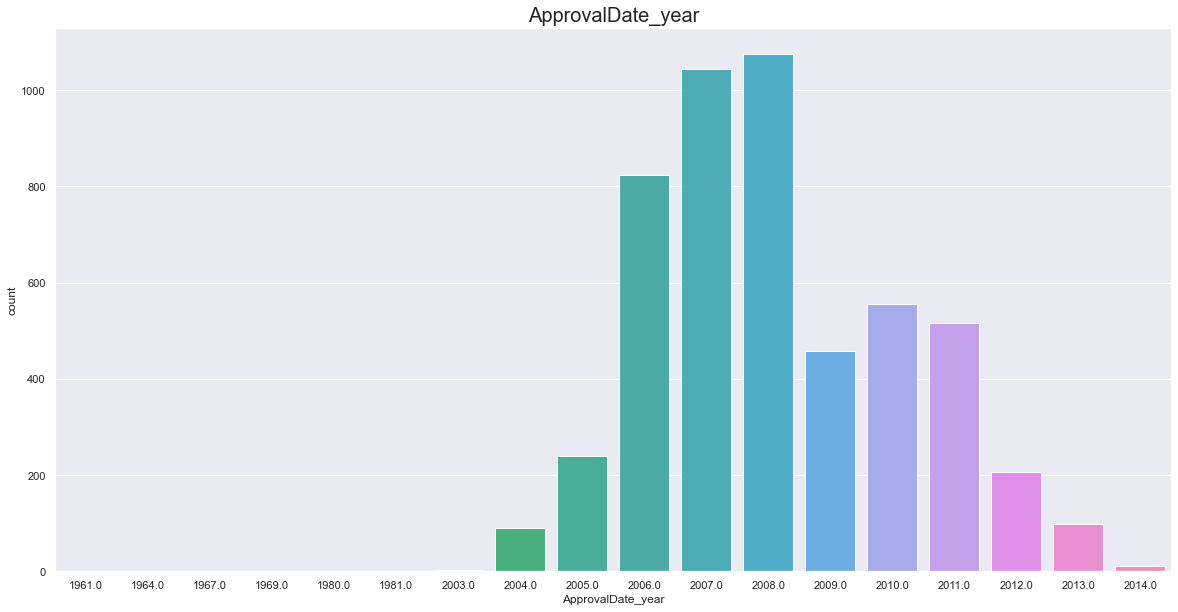

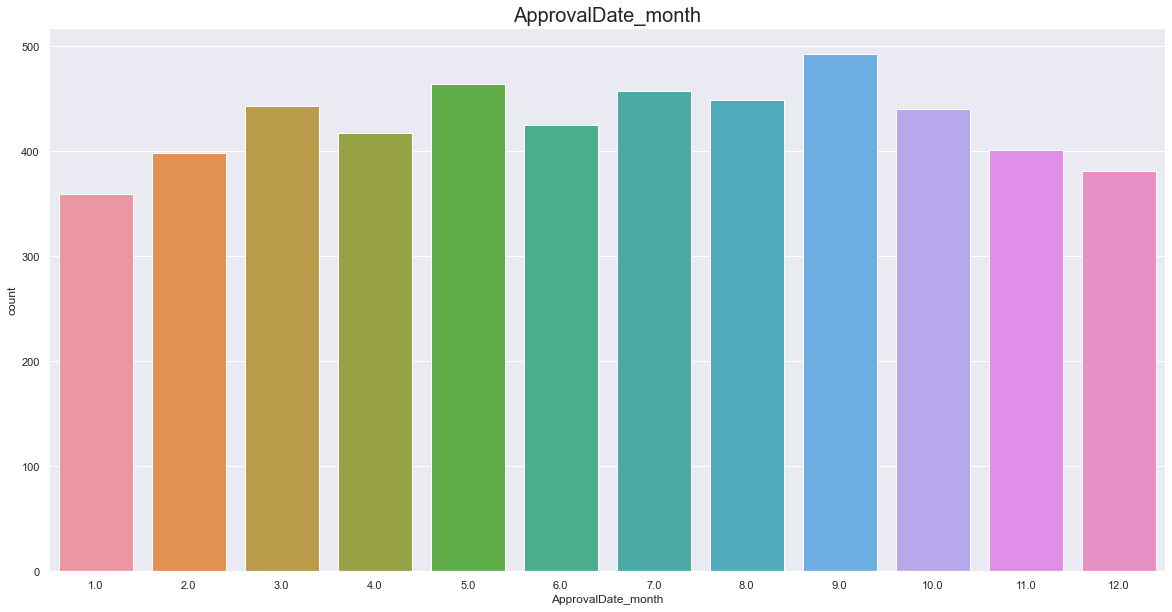

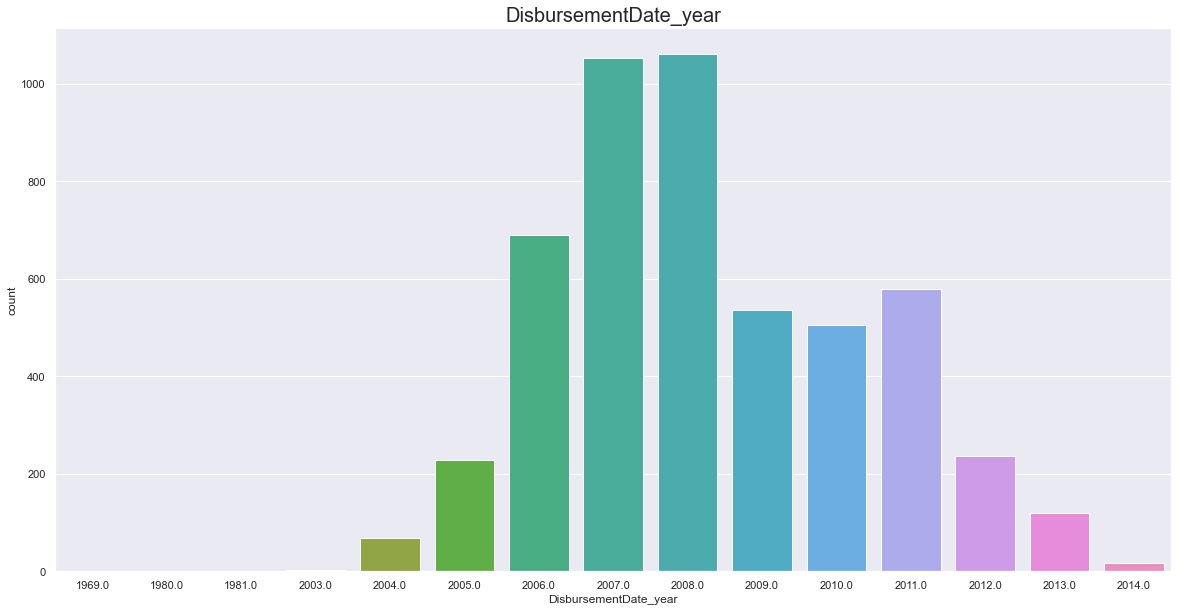

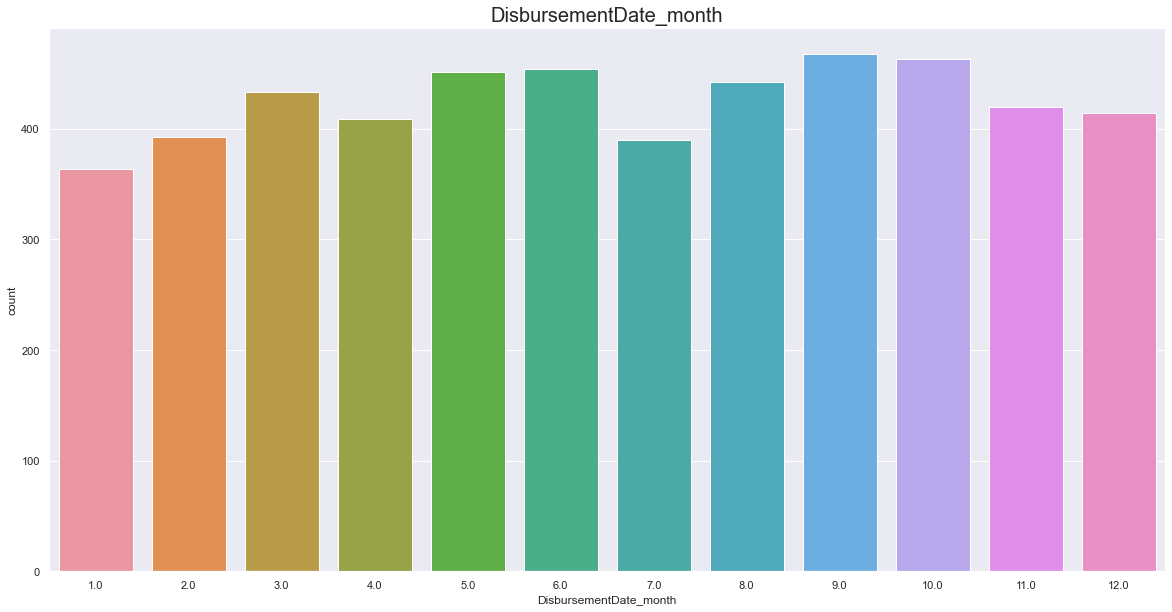

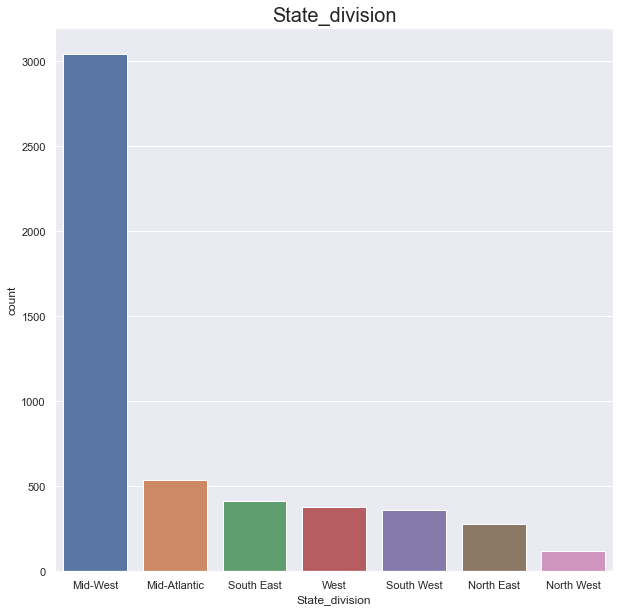

In [16]:
obj_visualization(df_emp0, obj_features)

In [17]:
df_emp0['UrbanRural'].value_counts()

 1    4187
 0     932
-1       8
Name: UrbanRural, dtype: int64

# CreateJob相關問題

In [18]:
display(df_copy[(df_copy['DisbursementDate_year'] == 1987)][['CreateJob', 'DisbursementDate_year']].describe())
display(df_copy[(df_copy['DisbursementDate_year'] == 2006)][['CreateJob', 'DisbursementDate_year']].describe())

,CreateJob,DisbursementDate_year
count,1860.000000,1860.0
mean,8.118280,1987.0
std,120.933268,0.0
min,0.000000,1987.0
25%,0.000000,1987.0
50%,0.000000,1987.0
75%,6.000000,1987.0
max,5199.000000,1987.0


,CreateJob,DisbursementDate_year
count,78746.000000,78746.0
mean,2.206842,2006.0
std,12.358535,0.0
min,0.000000,2006.0
25%,0.000000,2006.0
50%,0.000000,2006.0
75%,2.000000,2006.0
max,2020.000000,2006.0


In [19]:
# weird data create so many job(>=500)
df_job_weird = df_copy[(df_copy['CreateJob'] >= 500)| (df_copy['RetainedJob'] >= 500) & (df_copy['NoEmp'] < 500)].sort_values(by=['CreateJob', 'DisbursementDate_year'], ascending=False)
df_job_weird[['Name', 'State', 'CreateJob', 'RetainedJob', 'NoEmp', 'DisbursementDate_year', 'Term', 'Industry', 'IsFranchised', 'Default']].head(5)

,Name,State,CreateJob,RetainedJob,NoEmp,DisbursementDate_year,Term,Industry,IsFranchised,Default
525290,THE VILLAGE DRESS BOUTIQUE,TX,5621.0,0.0,13.0,1993.0,240.0,Retail_trade,0.0,0.0
253523,SBA/ROGER C & LUANN MCDOWELL,MO,5199.0,0.0,10.0,1987.0,240.0,Unknown,0.0,0.0
684149,CHILES FOOD SERVICE,MO,5085.0,0.0,80.0,2004.0,84.0,Accom/Food_serv,0.0,0.0
282937,JACK-IN-THE-BOX,AZ,3500.0,0.0,3500.0,1988.0,240.0,Unknown,1.0,0.0
355839,"CLASSICKLE, INC.",KY,3100.0,31.0,44.0,2000.0,240.0,Prof/Science/Tech,0.0,0.0


new distribution

In [20]:
# year_col_visualization(df_copy, num_features=['CreateJob', 'RetainedJob'], year_col='DisbursementDate_year')

In [21]:
# month_col_visualization(df_copy, num_features=['CreateJob', 'RetainedJob'], mon_col='DisbursementDate_month')

# USDPerJobCreated

In [22]:
df_copy.drop(list(df_copy[df_copy['DisbursementGross'] == 0].index), axis=0, inplace=True)
df4 = df_copy.copy()
df4.drop('USDPerJobCreated', axis=1, inplace=True)
df4['USDPerJobCreated'] = df4['DisbursementGross'] / df4['CreateJob']
df4['USDPerJobCreated'] = df4['USDPerJobCreated'].astype('str').apply(lambda x: x.replace(str(np.inf), str(np.nan))).astype('float64')

In [23]:
df_copy.drop('USDPerJobCreated', axis=1, inplace=True)
df_copy = pd.concat([df_copy, df4['USDPerJobCreated']], axis=1)
display(df_copy[['DisbursementGross', 'CreateJob', 'USDPerJobCreated', 'GrAppv', 'SBA_Appv']].describe())
print(df_copy.shape)

,DisbursementGross,CreateJob,USDPerJobCreated,GrAppv,SBA_Appv
count,8.942560e+05,894256.000000,2.670230e+05,8.942560e+05,8.942560e+05
mean,2.861743e+05,2.079013,8.584258e+04,2.762790e+05,2.156819e+05
std,3.955357e+05,16.232171,1.568652e+05,3.933194e+05,3.146792e+05
min,1.174334e+00,0.000000,1.212217e+00,2.424433e+02,1.212217e+02
25%,5.708814e+04,0.000000,1.832583e+04,4.529671e+04,2.757536e+04
50%,1.370894e+05,0.000000,4.263588e+04,1.242843e+05,8.849418e+04
75%,3.418290e+05,1.000000,8.656732e+04,3.290280e+05,2.598318e+05
max,1.311624e+07,5621.000000,9.746813e+06,6.038203e+06,6.038203e+06


(894256, 45)


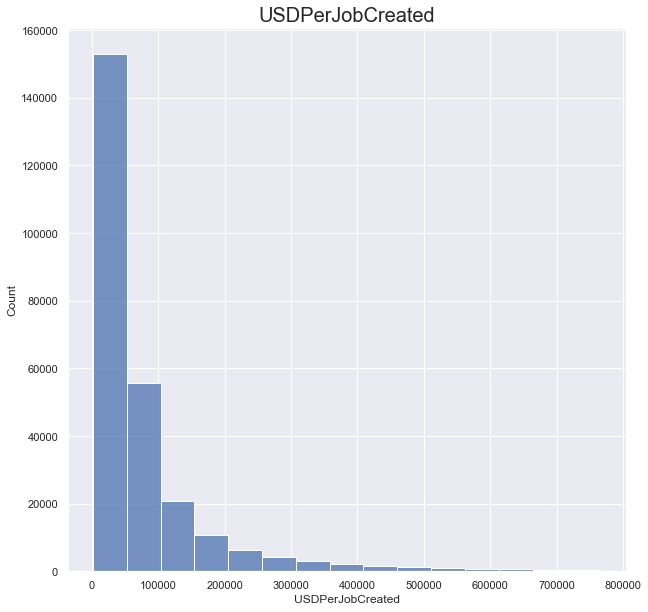

In [24]:
num_visualization(df_copy, ['USDPerJobCreated'])

# Default analysis

,ChgOffPrinGr,Default
6,378606.247444,1.0
36,18830.104233,1.0
43,88830.232921,1.0


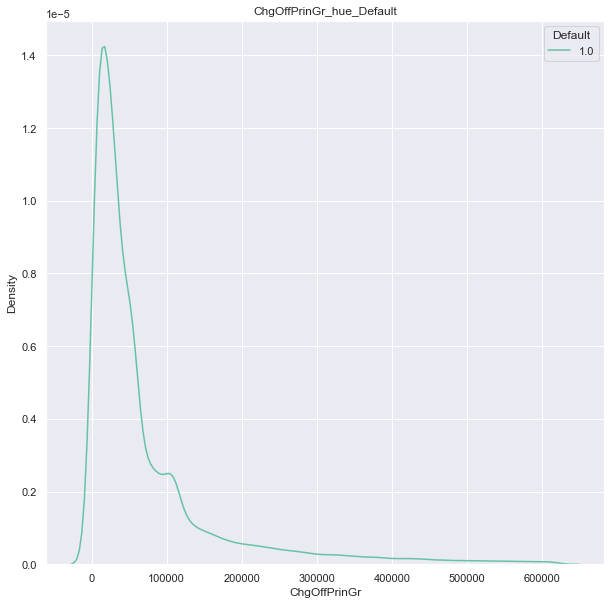

,Term,Default
0,84.0,0.0
1,60.0,0.0
2,180.0,0.0


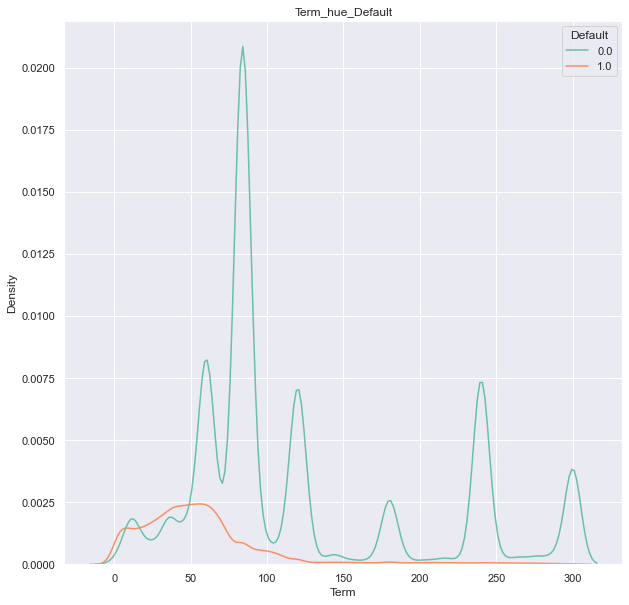

,DisbursementGross,Default
0,90558.780300,0.0
1,60372.520200,0.0
2,433172.832435,0.0


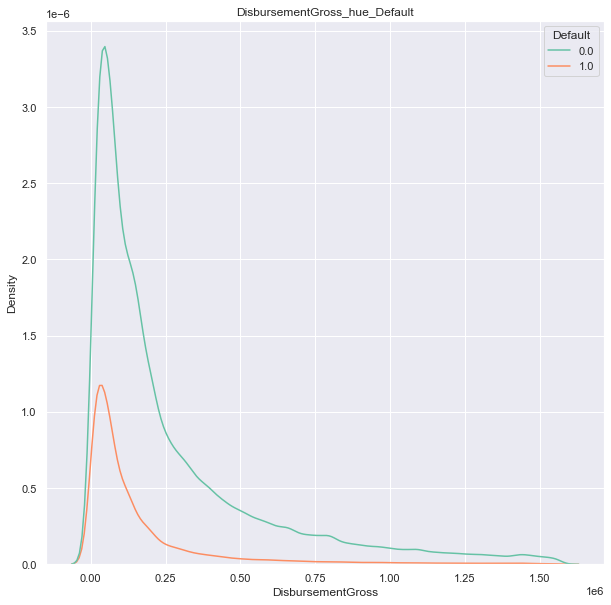

,GrSBA_AppvDiff%,Default
0,20.0,0.0
1,20.0,0.0
2,25.0,0.0


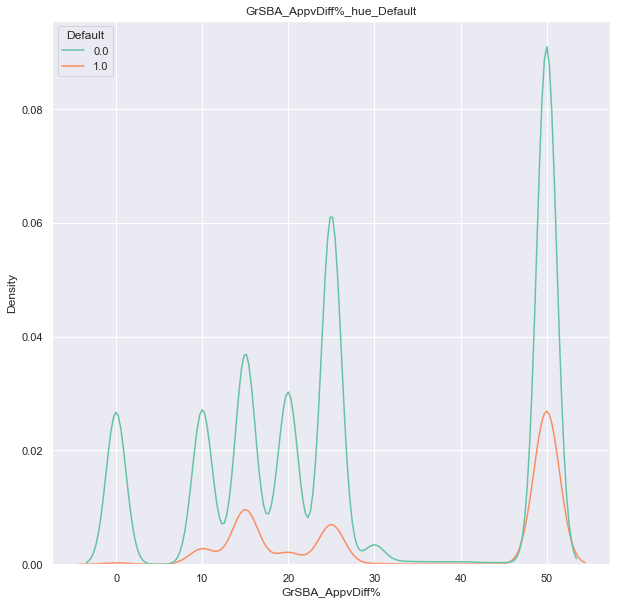

,DisbursePerEmployee,Default
0,12000.000000,0.0
1,13333.333333,0.0
2,35875.000000,0.0


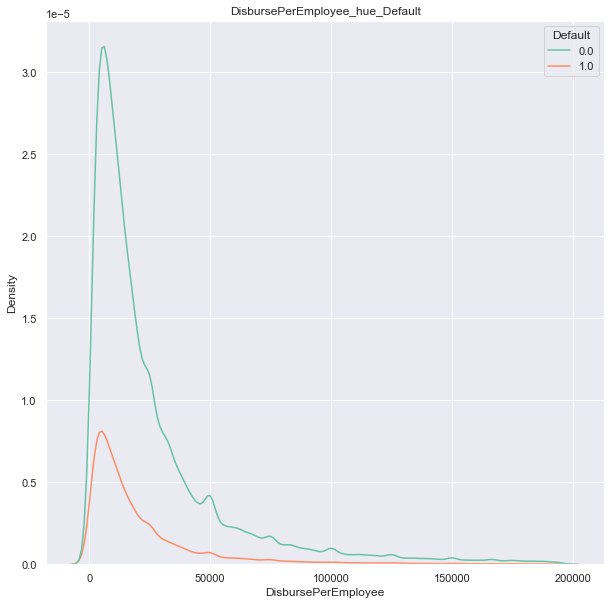

,USDPerJobCreated,Default
4,49376.096878,0.0
14,11319.847537,0.0
28,106321.347310,0.0


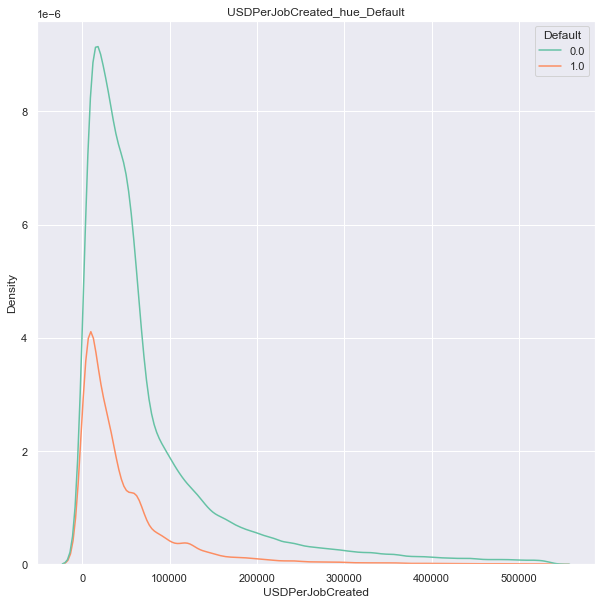

,NoEmp,Default
0,4.0,0.0
1,2.0,0.0
2,7.0,0.0


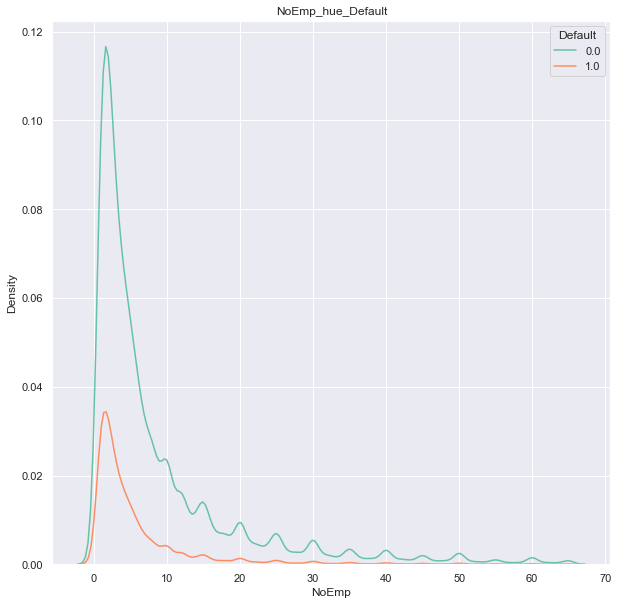

,CreateJob,Default
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


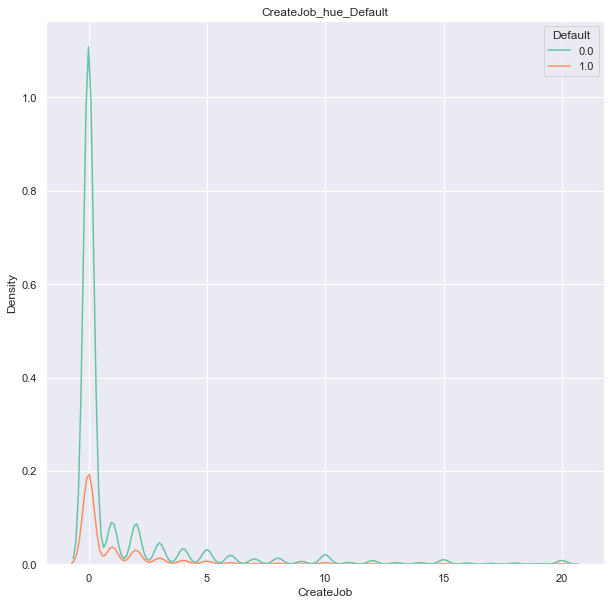

,RetainedJob,Default
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


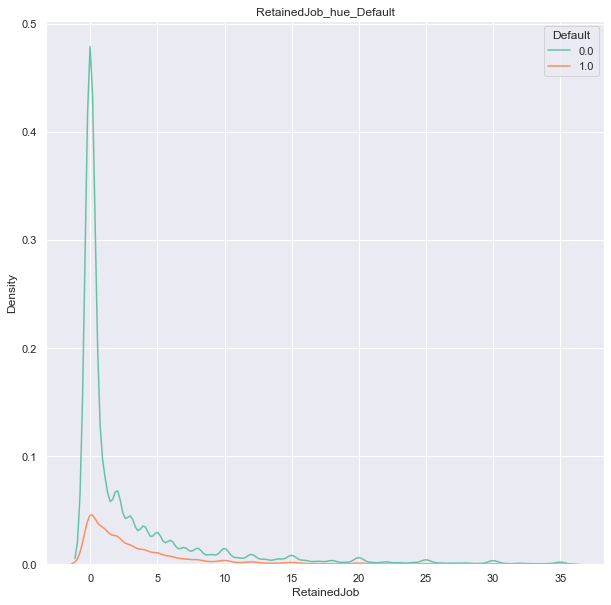

,Population,Default
0,31457.0,0.0
1,30671.0,0.0
2,41011.0,0.0


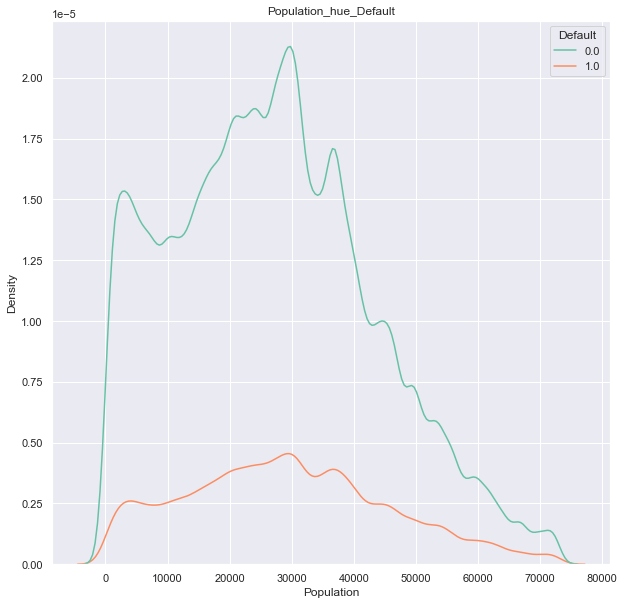

,PopDensity,Default
0,1939.0,0.0
1,457.0,0.0
2,495.0,0.0


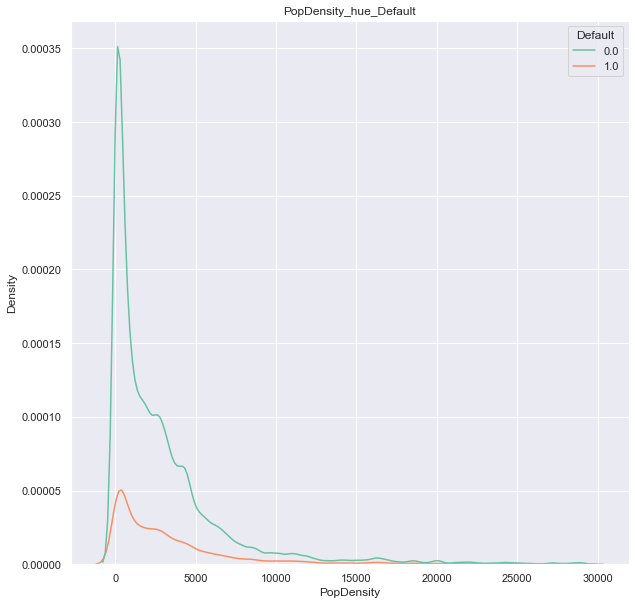

,GrAppv,Default
0,90558.780300,0.0
1,60372.520200,0.0
2,433172.832435,0.0


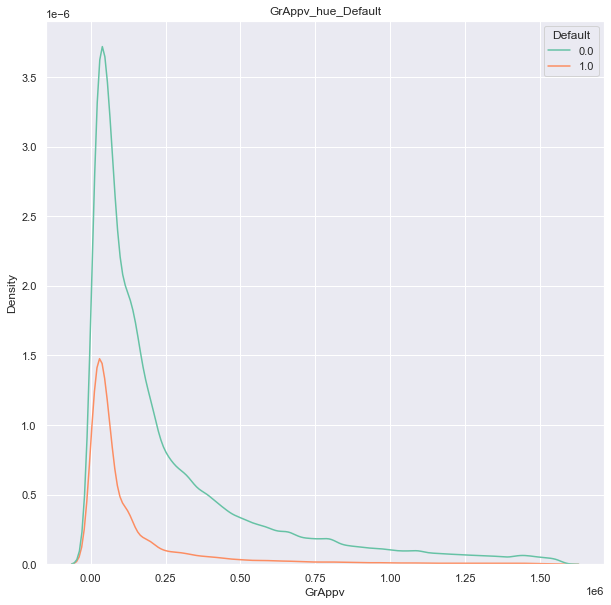

,SBA_Appv,Default
0,72447.024240,0.0
1,48298.016160,0.0
2,324879.624326,0.0


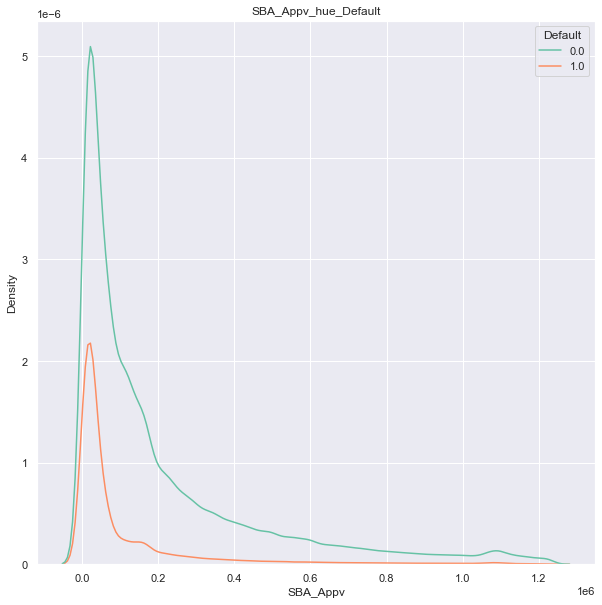

,HousingUnits,Default
0,14267.0,0.0
1,11847.0,0.0
2,19124.0,0.0


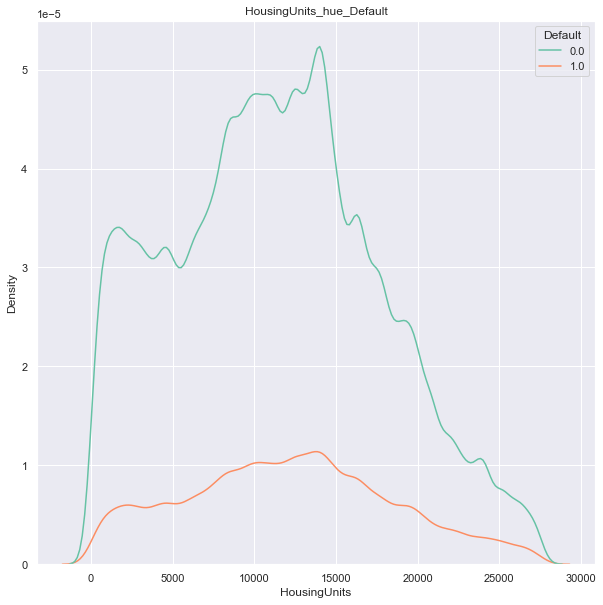

,OccupiedHousingUnits,Default
0,12895.0,0.0
1,10938.0,0.0
2,17562.0,0.0


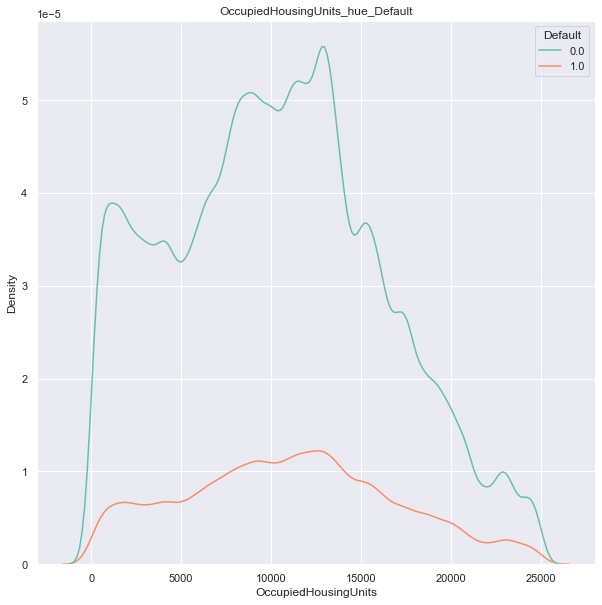

,MedianHomeValue,Default
0,115600.0,0.0
1,120200.0,0.0
2,207900.0,0.0


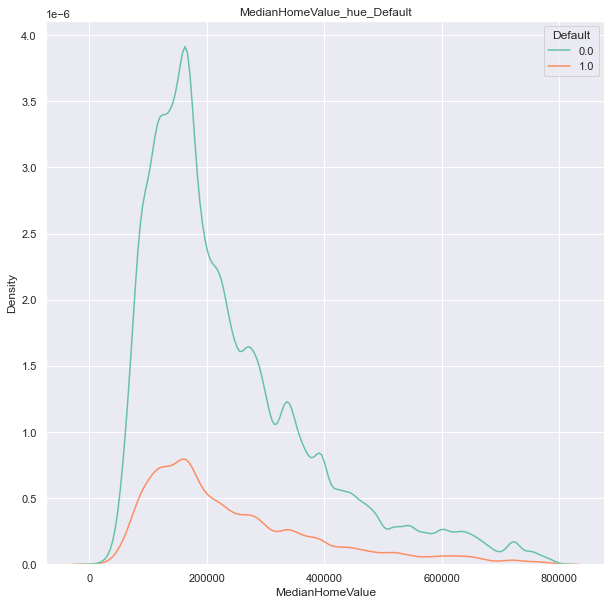

,MedianHouseholdIncome,Default
0,48618.0,0.0
1,47863.0,0.0
2,45415.0,0.0


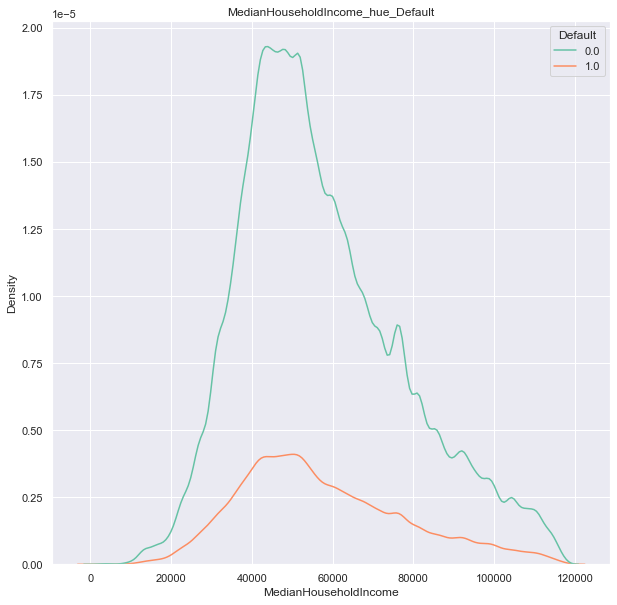

In [25]:
num_visualization_with_hue(df_copy, num_features, 'Default')

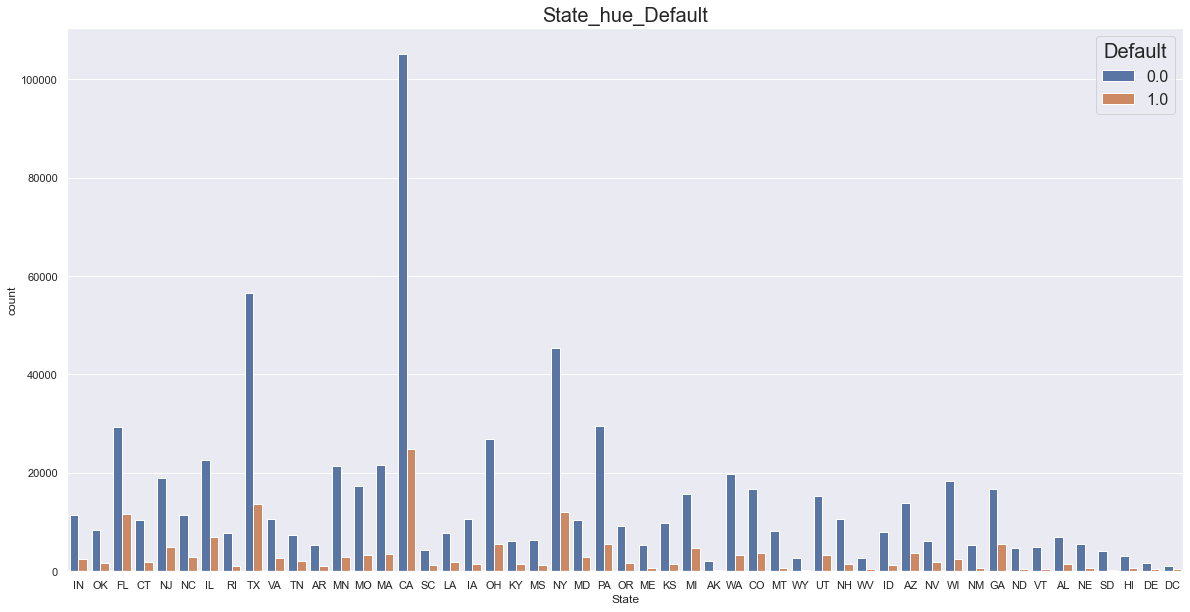

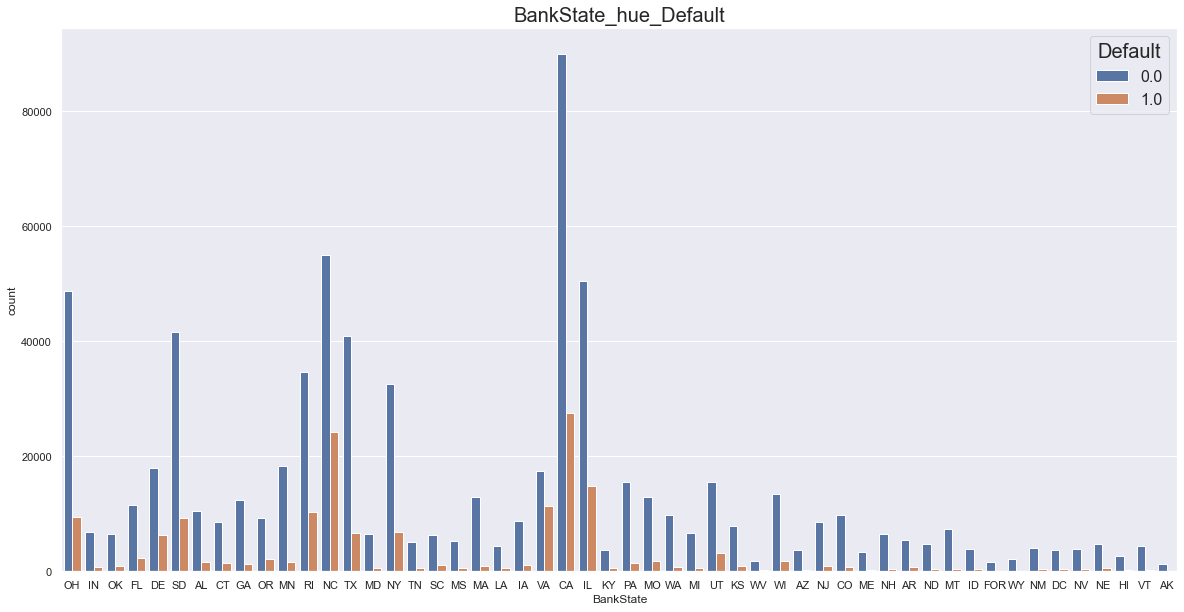

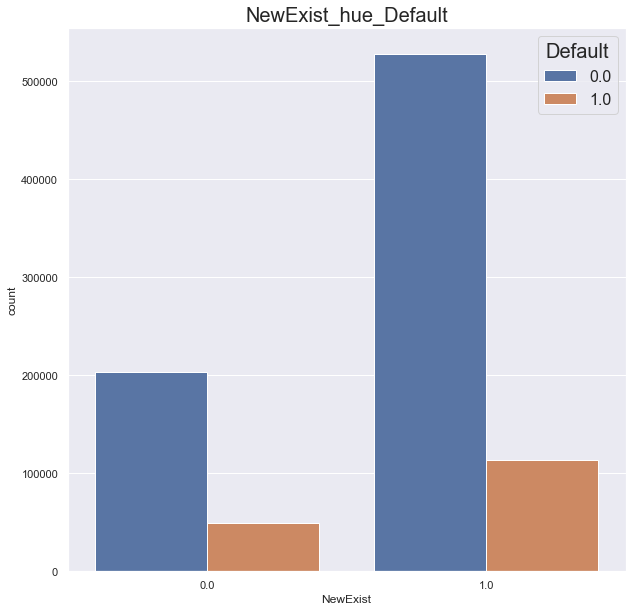

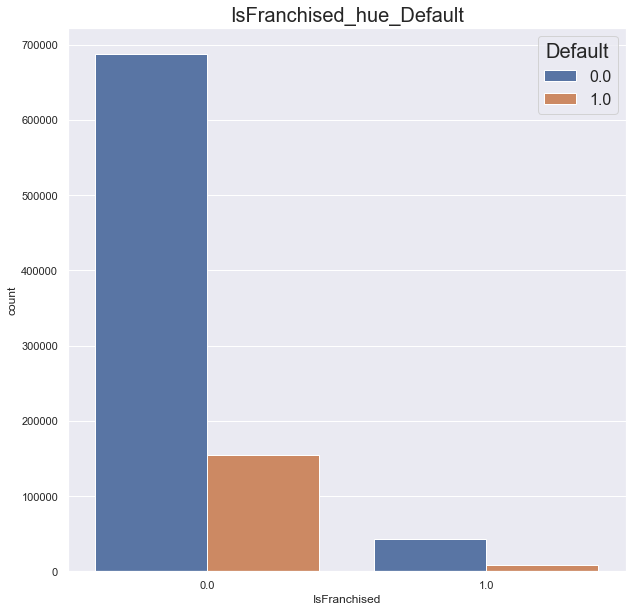

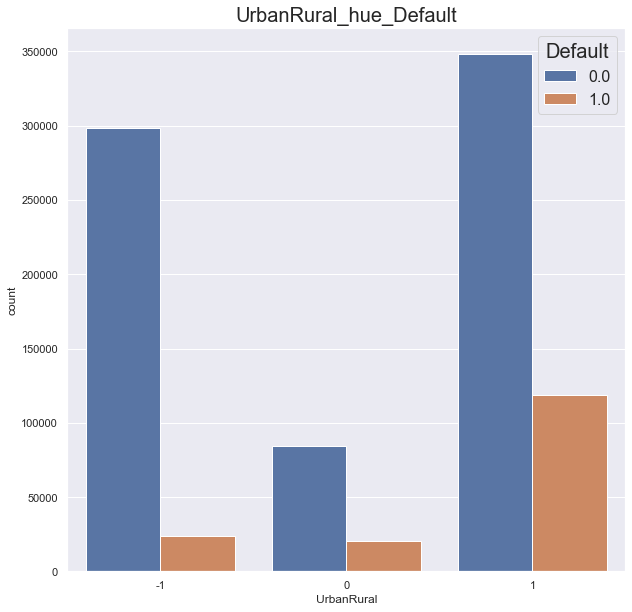

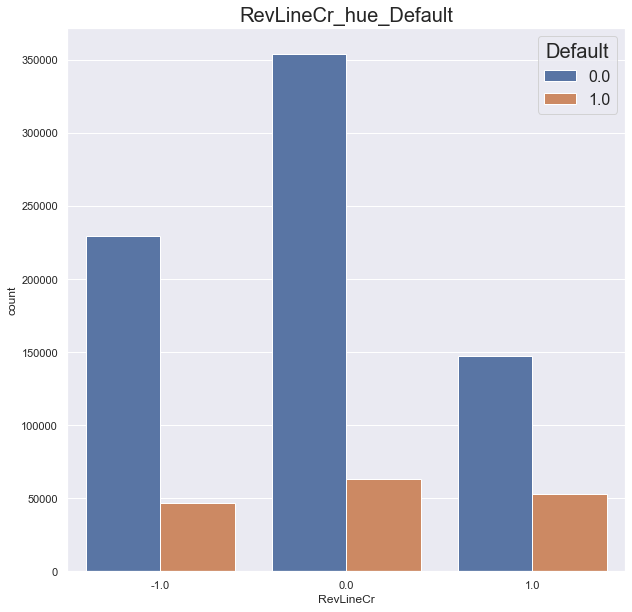

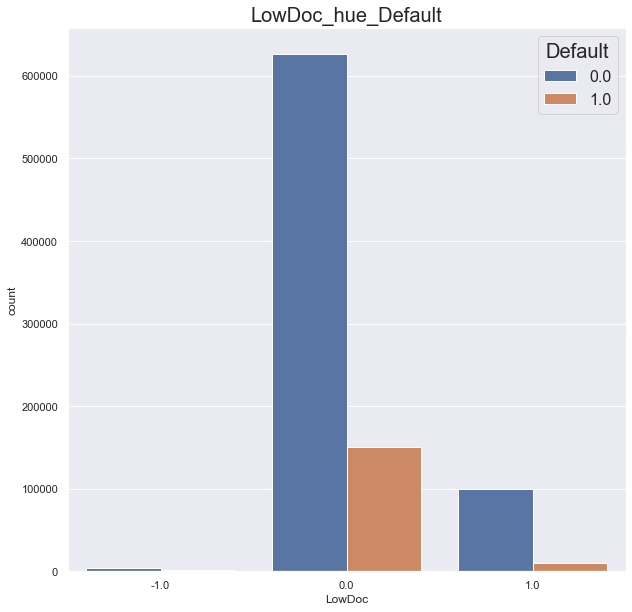

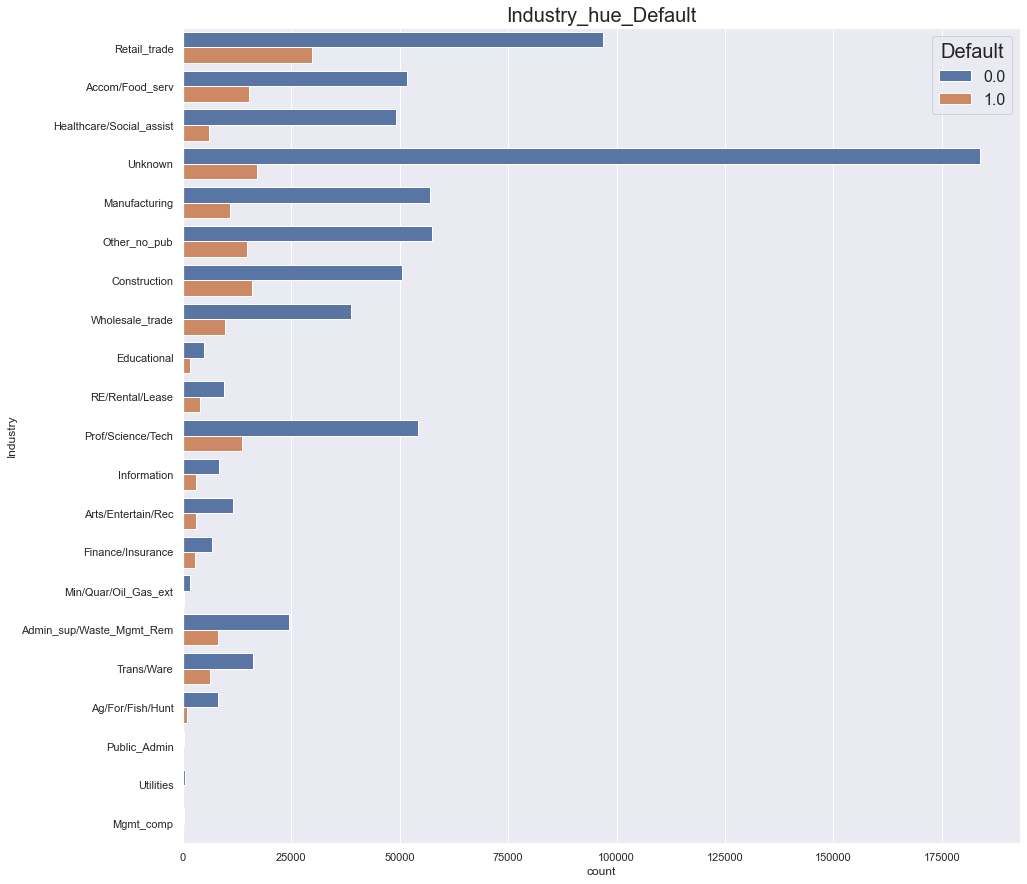

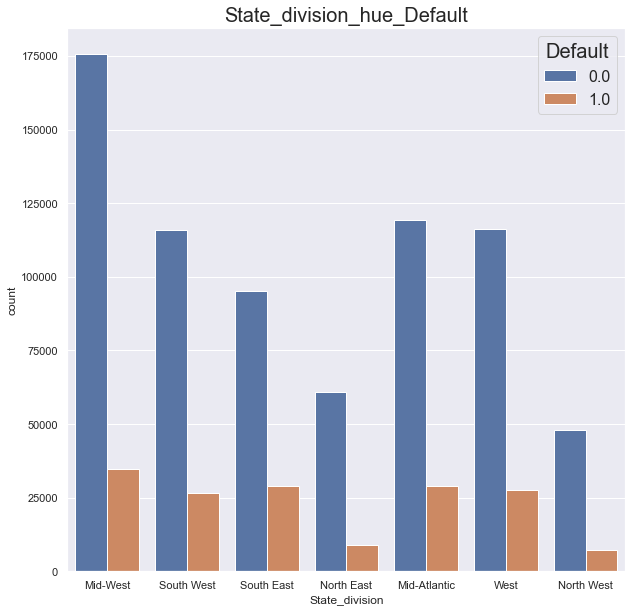

In [26]:
obj_visualization_with_hue(df_copy, obj_features, hue_col='Default')

# UrbanRural Undefined 

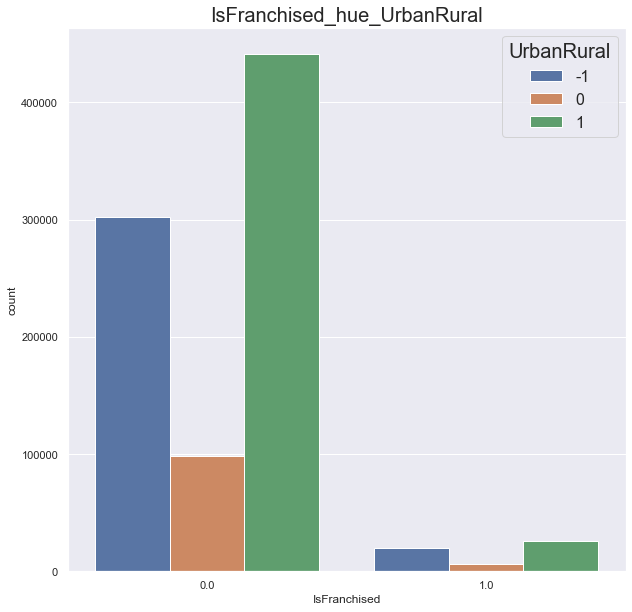

In [27]:
obj_visualization_with_hue(df_copy, ['IsFranchised'], hue_col='UrbanRural')

,NoEmp,UrbanRural
0,4.0,-1
1,2.0,-1
2,7.0,-1


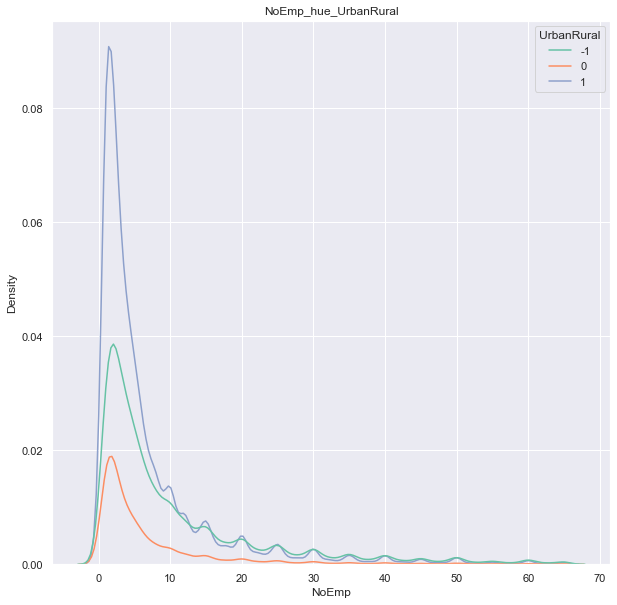

In [28]:
num_visualization_with_hue(df_copy, ['NoEmp'], 'UrbanRural')

# RevLineCr

In [29]:
df_rev = df_copy[df_copy['RevLineCr'] == -1]
df_rev.head(3)

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,ApprovalDate,Term,NoEmp,...,Population,PopDensity,HousingUnits,OccupiedHousingUnits,MedianHomeValue,MedianHouseholdIncome,DisbursePerEmployee,GrSBA_AppvDiff%,State_division,USDPerJobCreated
26,1000484004,"C & S TRANSIT, INC.",INDEPENDENCE,MO,64055,BANK OF AMERICA NATL ASSOC,NC,1997-02-28,60.0,2.0,...,33858.0,2768.0,16057.0,14903.0,112600.0,51375.0,16666.666667,50.0,Mid-West,NaN
38,1000576010,CORBIN CREEK GREENHOUSE,SPRINGFIELD,TN,37172,BBCN BANK,CA,2006-02-07,84.0,4.0,...,28714.0,159.0,11603.0,10635.0,138900.0,45964.0,4000.000000,15.0,South East,24244.33458
39,1000584010,JFJ PROCESSORS,LEWISBURG,TN,37091,FIRST FARMERS & MERCHANTS BK,TN,1997-02-28,180.0,7.0,...,21005.0,101.0,9157.0,8231.0,98600.0,37174.0,30625.000000,25.0,South East,NaN


In [30]:
data = df_copy.groupby(by=['DisbursementDate_year', 'RevLineCr']).mean()
data_long = data.melt(ignore_index=False).reset_index()
data_def = data_long[data_long['variable'] == 'Default']
data_def.head(3)

,DisbursementDate_year,RevLineCr,variable,value
1212,1948.0,0.0,Default,1.000000
1213,1968.0,0.0,Default,1.000000
1214,1969.0,0.0,Default,0.666667


In [31]:
data_def = data_def[data_def['DisbursementDate_year'] >= 1972]
data_def[['DisbursementDate_year', 'RevLineCr']] = data_def[['DisbursementDate_year', 'RevLineCr']].applymap(lambda x: int(x))
data_def.head(3)

,DisbursementDate_year,RevLineCr,variable,value
1217,1972,0,Default,0.971429
1218,1973,0,Default,0.977778
1219,1974,0,Default,1.000000


In [32]:
year_list = list(df_groupby_mean['ApprovalDate_year'][~(df_groupby_size['ApprovalDate_year']['size'] < 30)].index)

In [33]:
data = pd.DataFrame(df_copy.groupby(by=['DisbursementDate_year', 'RevLineCr']).size()).reset_index()
data.rename(columns={0: 'count'}, inplace=True)
data = data[data['DisbursementDate_year'] >= 1972]
data[['DisbursementDate_year', 'RevLineCr']] = data[['DisbursementDate_year', 'RevLineCr']].applymap(lambda x: int(x))
data.head(3)

,DisbursementDate_year,RevLineCr,count
5,1972,0,35
6,1973,0,45
7,1974,0,35


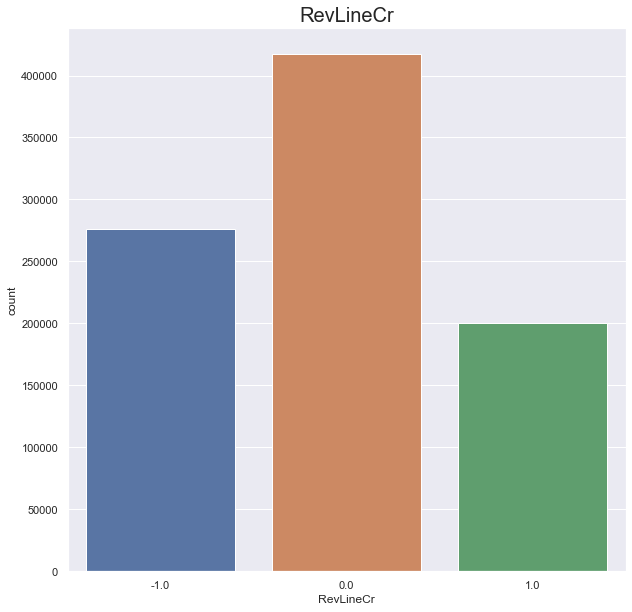

In [42]:
obj_visualization(df_copy, ['RevLineCr'])

In [44]:
pd.DataFrame(df_copy.groupby(by=['LowDoc', 'RevLineCr']).size())

0
LowDoc RevLineCr        
-1.0   -1.0          893
        0.0         4135
        1.0          913
 0.0   -1.0       222618
        0.0       356206
        1.0       199188
 1.0   -1.0        52892
        0.0        57355
        1.0           56

In [34]:
# # save figure
# plt.figure(figsize=(20,10))
# plt.title('Size by DisbursementDate_year_RevLineCr'.format(num))
# plt.grid(True)
# plt.vlines(x=[2006.0], ymin=data['count'].min(), ymax=data['count'].max(), color='r', linestyles='dashed')
# sns.lineplot(data=data, x=data['DisbursementDate_year'], y=data['count'], marker=True, hue='RevLineCr',
#              palette="flare")
# plt.legend(title='RevLineCr', fontsize=20, title_fontsize=20)
# plt.savefig('RevLineCr Size by DisbursementDate_year.jpeg')

# plt.show()

In [35]:
# # Disbursement year
# plt.figure(figsize=(20,22))

# num = 'Default'

# plt.subplot(2, 1, 1)
# plt.title('Mean {} by DisbursementDate_year_RevLineCr'.format(num))
# plt.grid(True)
# plt.vlines(x=[2006.0], ymin=data_def['value'].min(), ymax=data_def['value'].max(), color='r', linestyles='dashed')
# sns.lineplot(data=data_def, x=data_def['DisbursementDate_year'], y=data_def['value'], marker=True, hue='RevLineCr',
#              palette="flare")
# plt.legend(title='RevLineCr', fontsize=20, title_fontsize=20)

# plt.subplot(2, 1, 2)
# plt.title('Size by DisbursementDate_year_RevLineCr'.format(num))
# plt.grid(True)
# plt.vlines(x=[2006.0], ymin=data['count'].min(), ymax=data['count'].max(), color='r', linestyles='dashed')
# sns.lineplot(data=data, x=data['DisbursementDate_year'], y=data['count'], marker=True, hue='RevLineCr',
#              palette="flare")
# plt.legend(title='RevLineCr', fontsize=20, title_fontsize=20)

# plt.show()

In [36]:
# for i in range(len(num_features)):
#     data = df_copy.groupby(by=['DisbursementDate_year', 'RevLineCr']).mean()
#     data_long = data.melt(ignore_index=False).reset_index()
#     data_def = data_long[data_long['variable'] == num_features[i]]

#     data_def = data_def[data_def['DisbursementDate_year'] >= 1972]
#     data_def[['DisbursementDate_year', 'RevLineCr']] = data_def[['DisbursementDate_year', 'RevLineCr']].applymap(lambda x: int(x))

#     year_list = list(df_groupby_mean['ApprovalDate_year'][~(df_groupby_size['ApprovalDate_year']['size'] < 30)].index)

#     plt.figure(figsize=(20,10))

#     num = num_features[i]

#     plt.title('Mean {} by DisbursementDate_year_RevLineCr'.format(num))
#     plt.grid(True)
#     plt.vlines(x=[2006.0], ymin=data_def['value'].min(), ymax=data_def['value'].max(), color='r', linestyles='dashed')
#     sns.lineplot(data=data_def, x=data_def['DisbursementDate_year'], y=data_def['value'], marker=True, hue='RevLineCr',
#                  palette="flare")
#     plt.legend(title='RevLineCr', fontsize=20, title_fontsize=20)
#     plt.savefig('Mean {} by DisbursementDate_year_RevLineCr.jpeg'.format(num))
#     plt.show()

,Default,RevLineCr
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


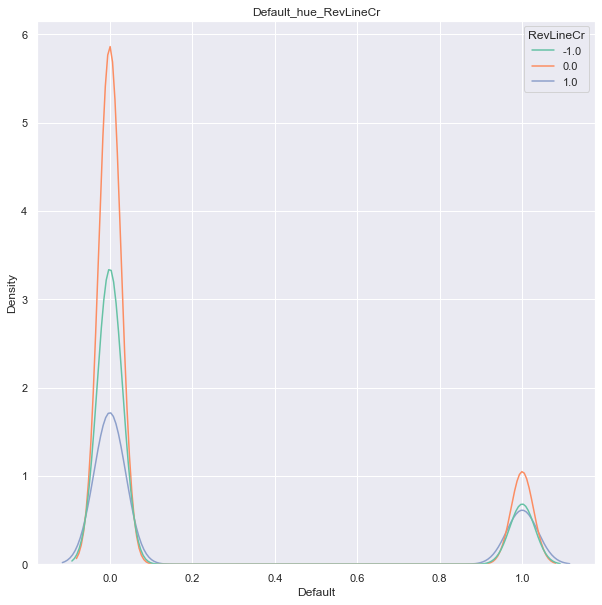

,ChgOffPrinGr,RevLineCr
6,378606.247444,0.0
36,18830.104233,0.0
43,88830.232921,1.0


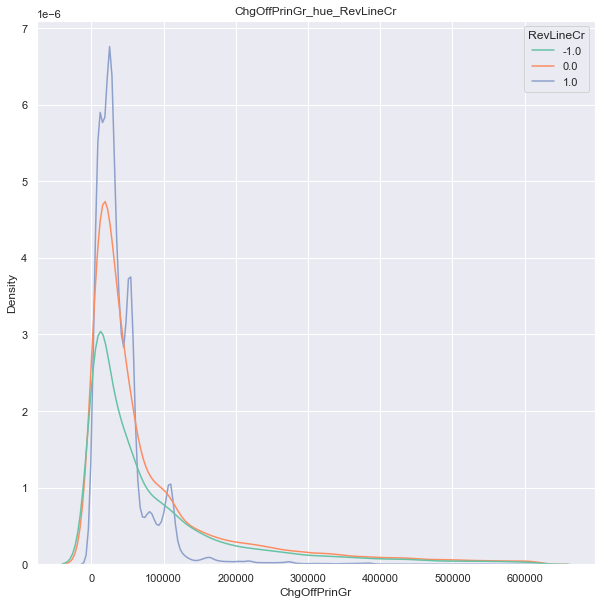

,Term,RevLineCr
0,84.0,0.0
1,60.0,0.0
2,180.0,0.0


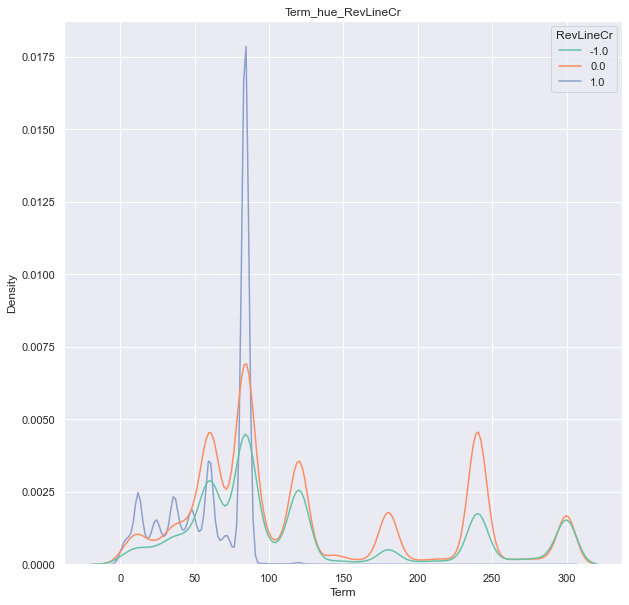

,DisbursementGross,RevLineCr
0,90558.780300,0.0
1,60372.520200,0.0
2,433172.832435,0.0


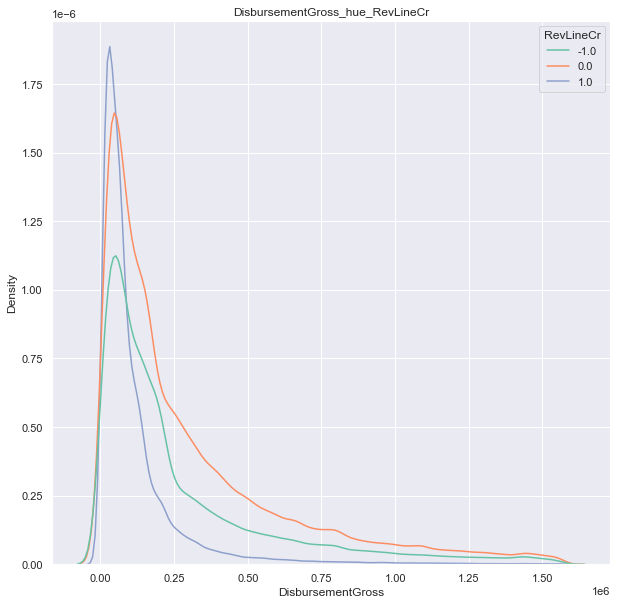

,GrSBA_AppvDiff%,RevLineCr
0,20.0,0.0
1,20.0,0.0
2,25.0,0.0


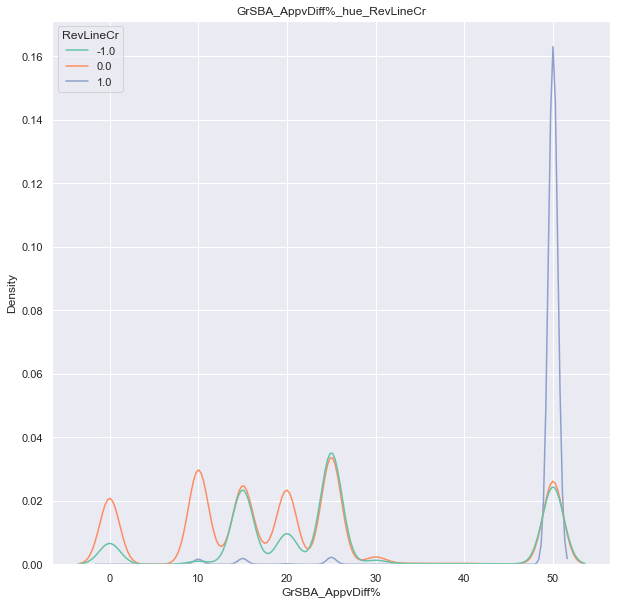

,DisbursePerEmployee,RevLineCr
0,12000.000000,0.0
1,13333.333333,0.0
2,35875.000000,0.0


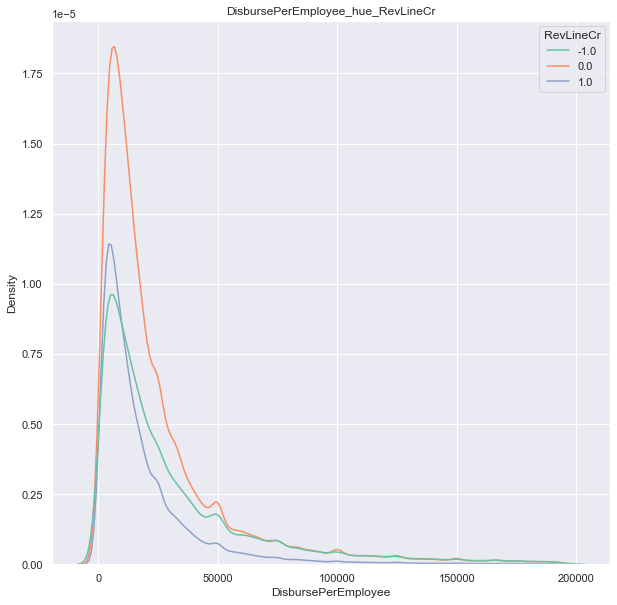

,USDPerJobCreated,RevLineCr
4,49376.096878,0.0
14,11319.847537,0.0
28,106321.347310,1.0


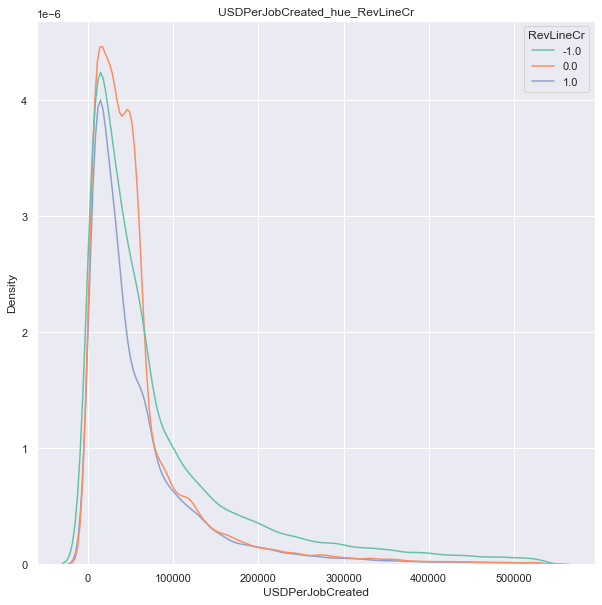

,NoEmp,RevLineCr
0,4.0,0.0
1,2.0,0.0
2,7.0,0.0


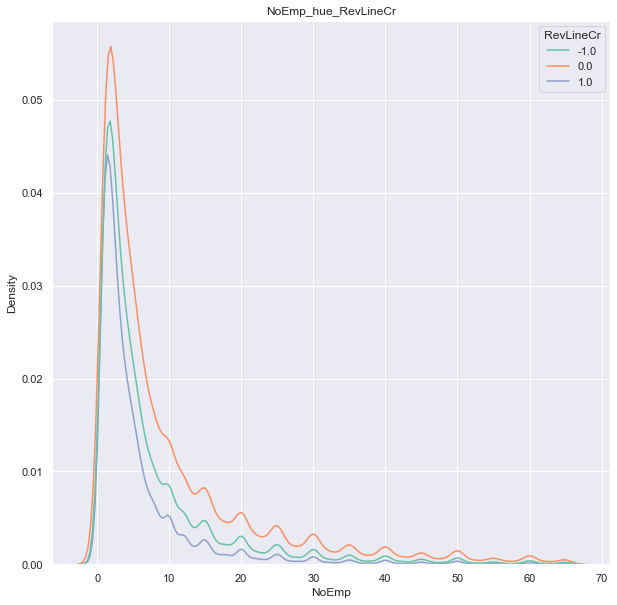

,CreateJob,RevLineCr
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


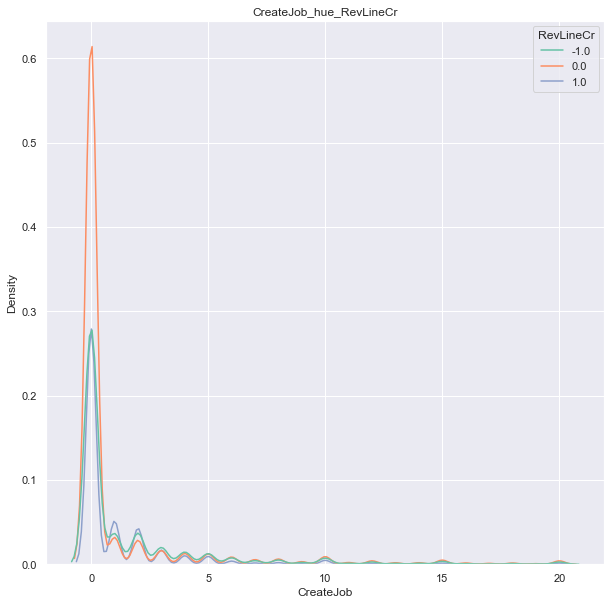

,RetainedJob,RevLineCr
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


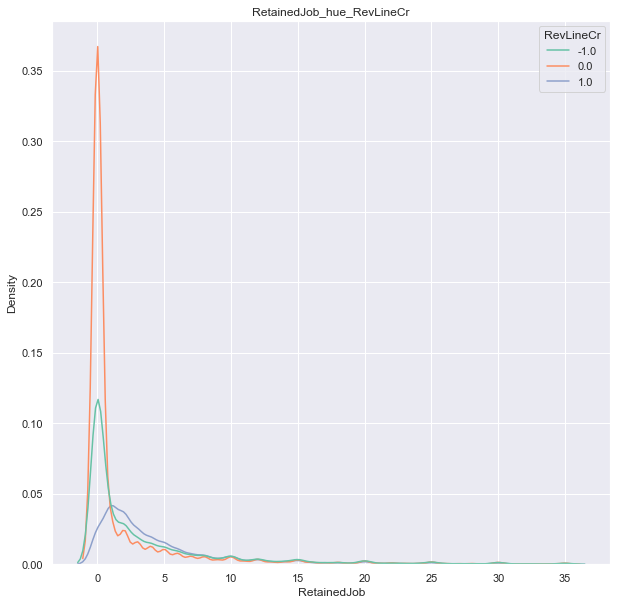

,Population,RevLineCr
0,31457.0,0.0
1,30671.0,0.0
2,41011.0,0.0


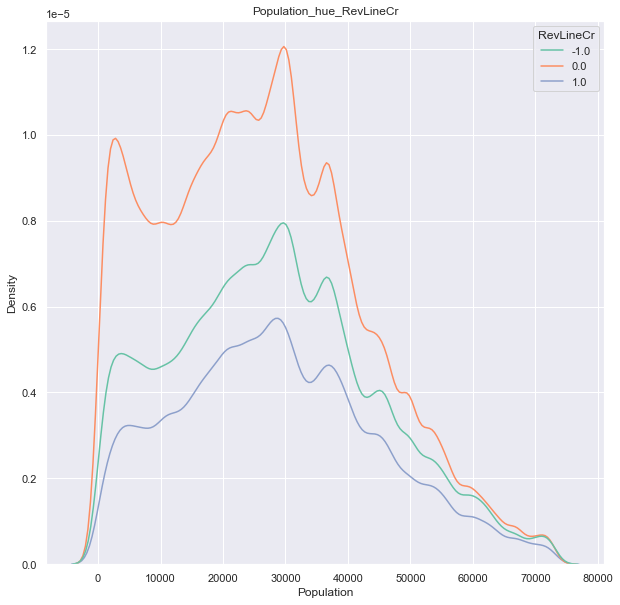

,PopDensity,RevLineCr
0,1939.0,0.0
1,457.0,0.0
2,495.0,0.0


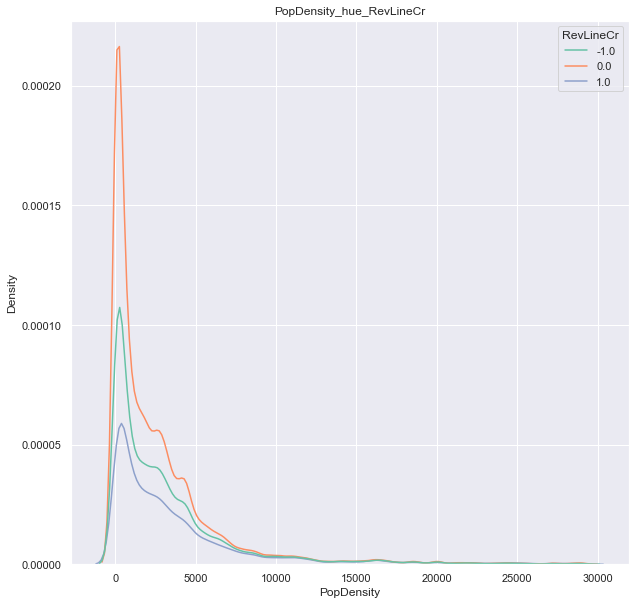

,GrAppv,RevLineCr
0,90558.780300,0.0
1,60372.520200,0.0
2,433172.832435,0.0


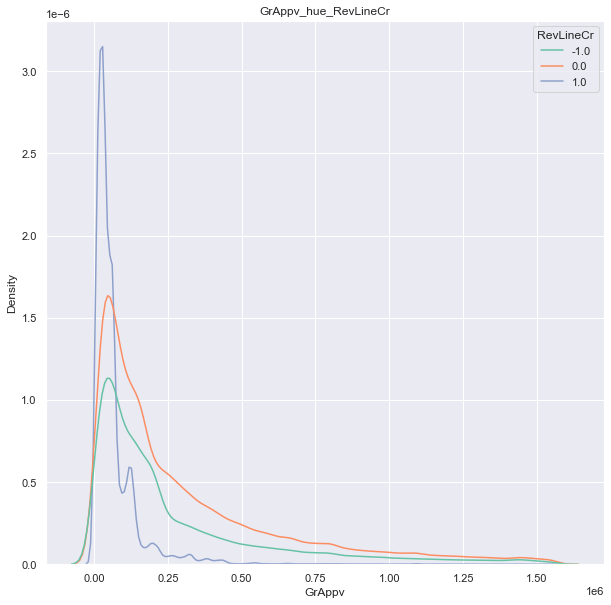

,SBA_Appv,RevLineCr
0,72447.024240,0.0
1,48298.016160,0.0
2,324879.624326,0.0


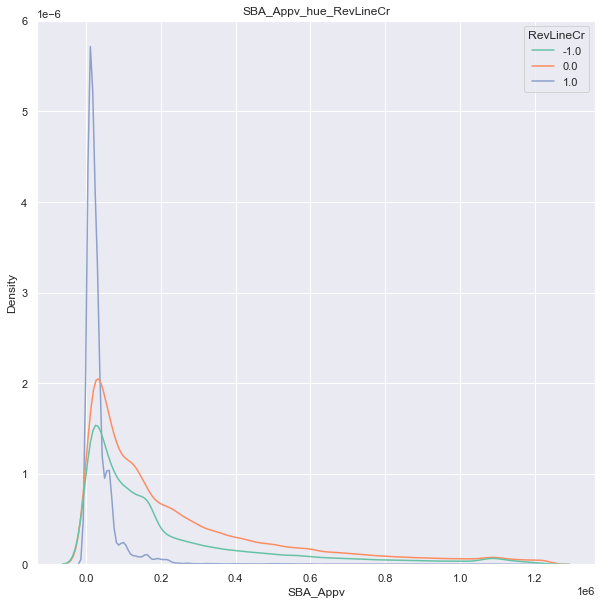

,HousingUnits,RevLineCr
0,14267.0,0.0
1,11847.0,0.0
2,19124.0,0.0


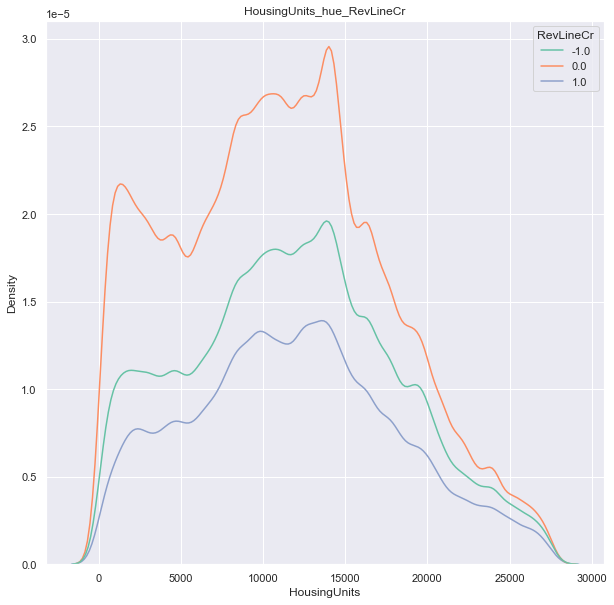

,OccupiedHousingUnits,RevLineCr
0,12895.0,0.0
1,10938.0,0.0
2,17562.0,0.0


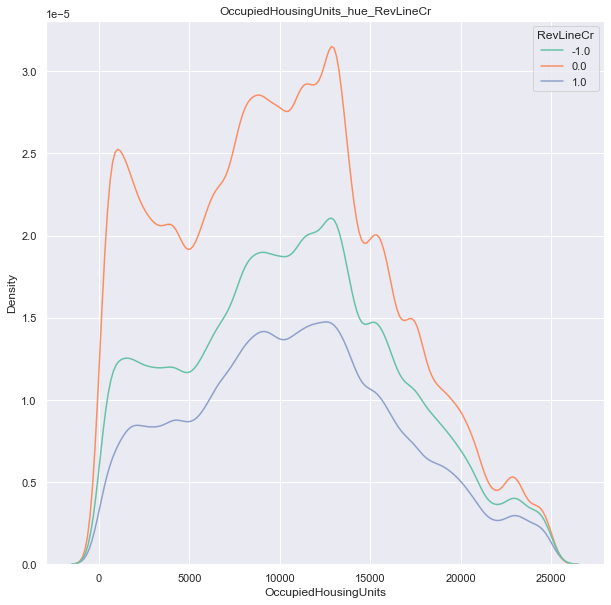

,MedianHomeValue,RevLineCr
0,115600.0,0.0
1,120200.0,0.0
2,207900.0,0.0


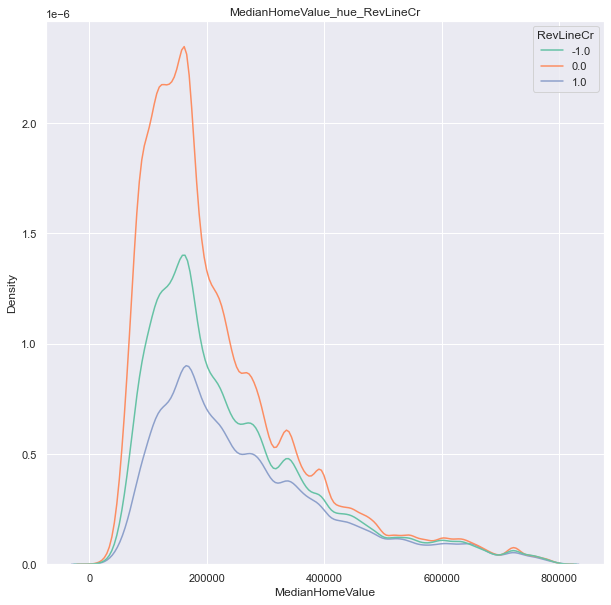

,MedianHouseholdIncome,RevLineCr
0,48618.0,0.0
1,47863.0,0.0
2,45415.0,0.0


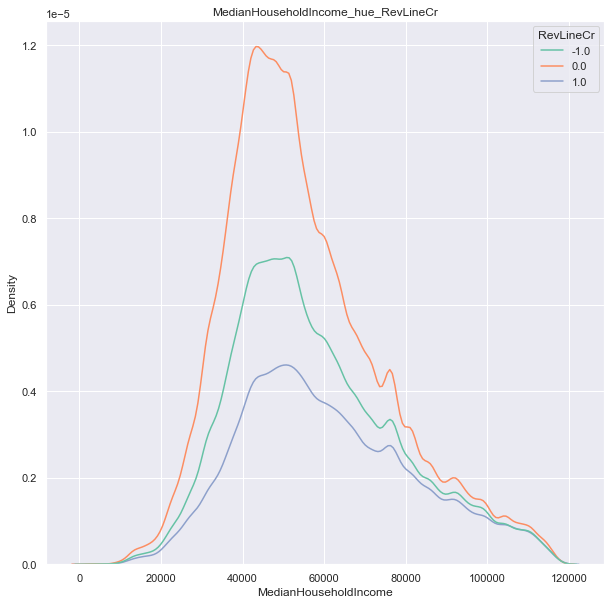

In [37]:
num_visualization_with_hue(df_copy, num_features, hue_col='RevLineCr')

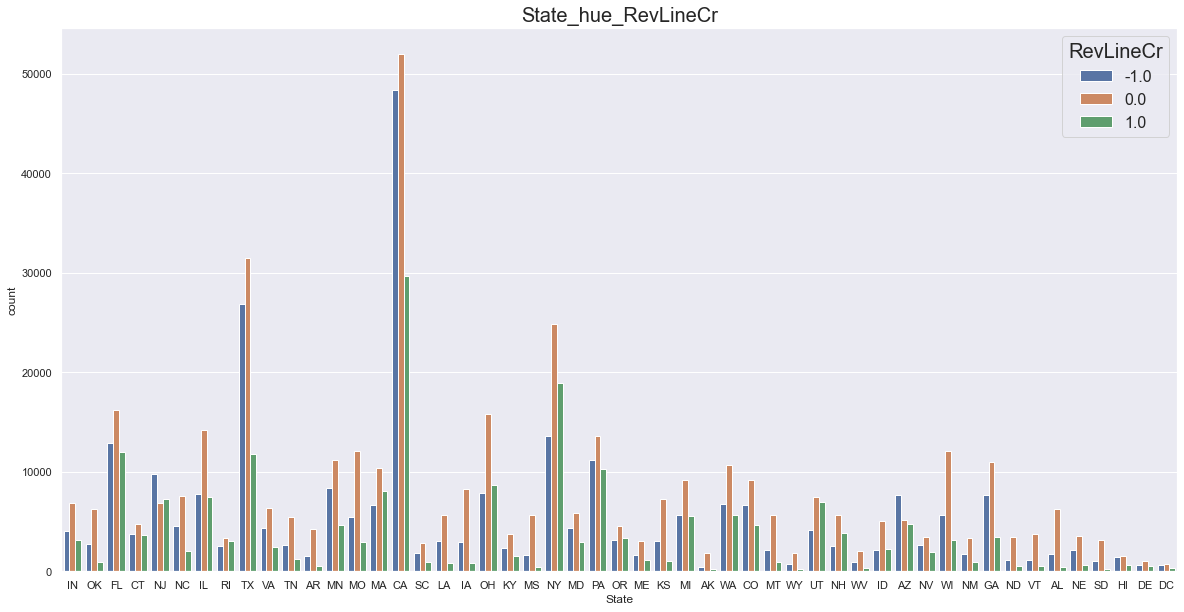

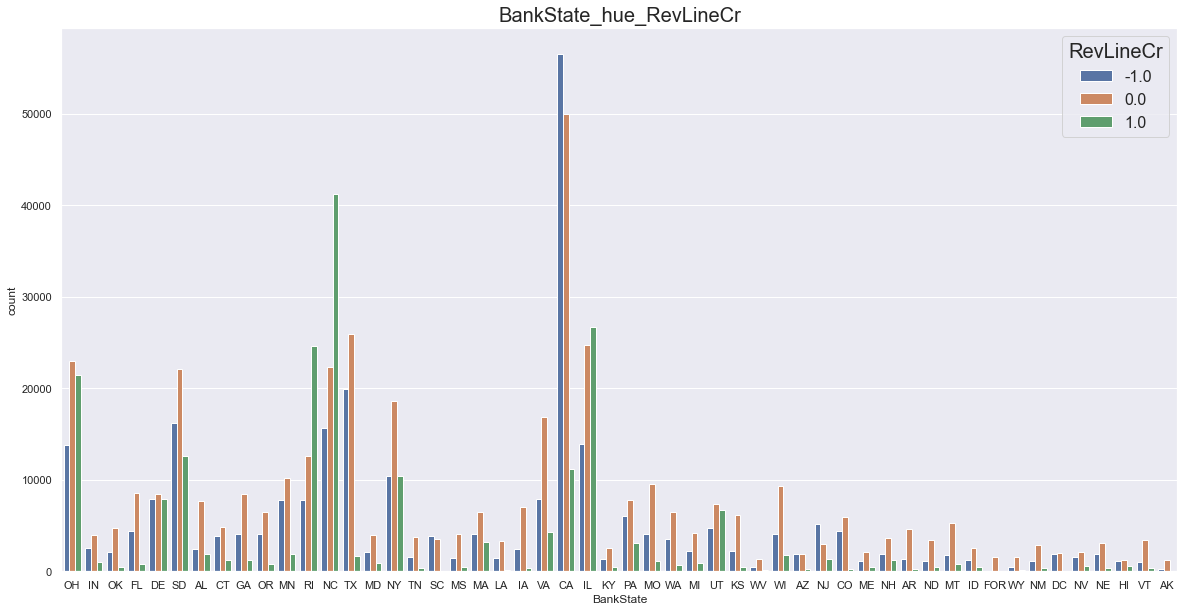

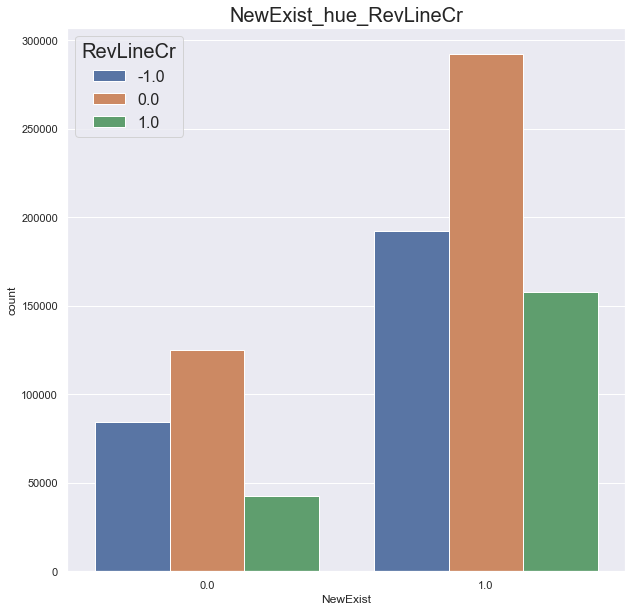

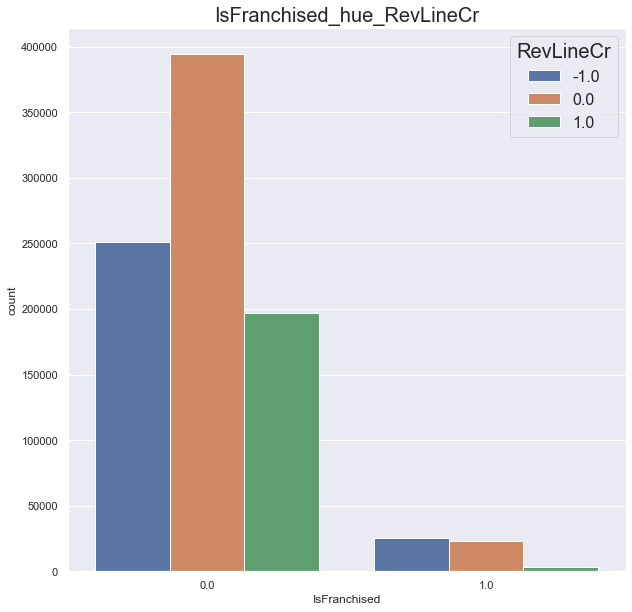

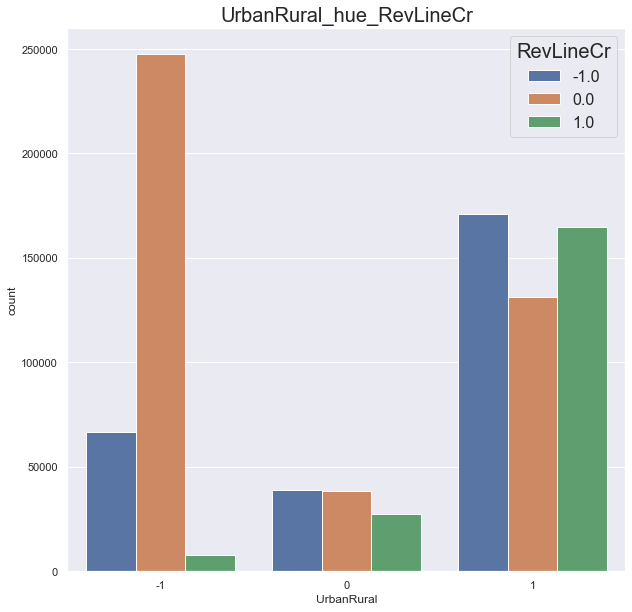

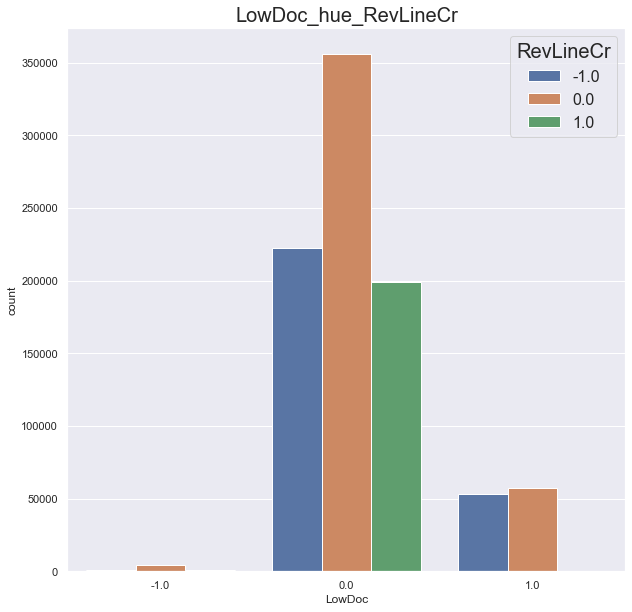

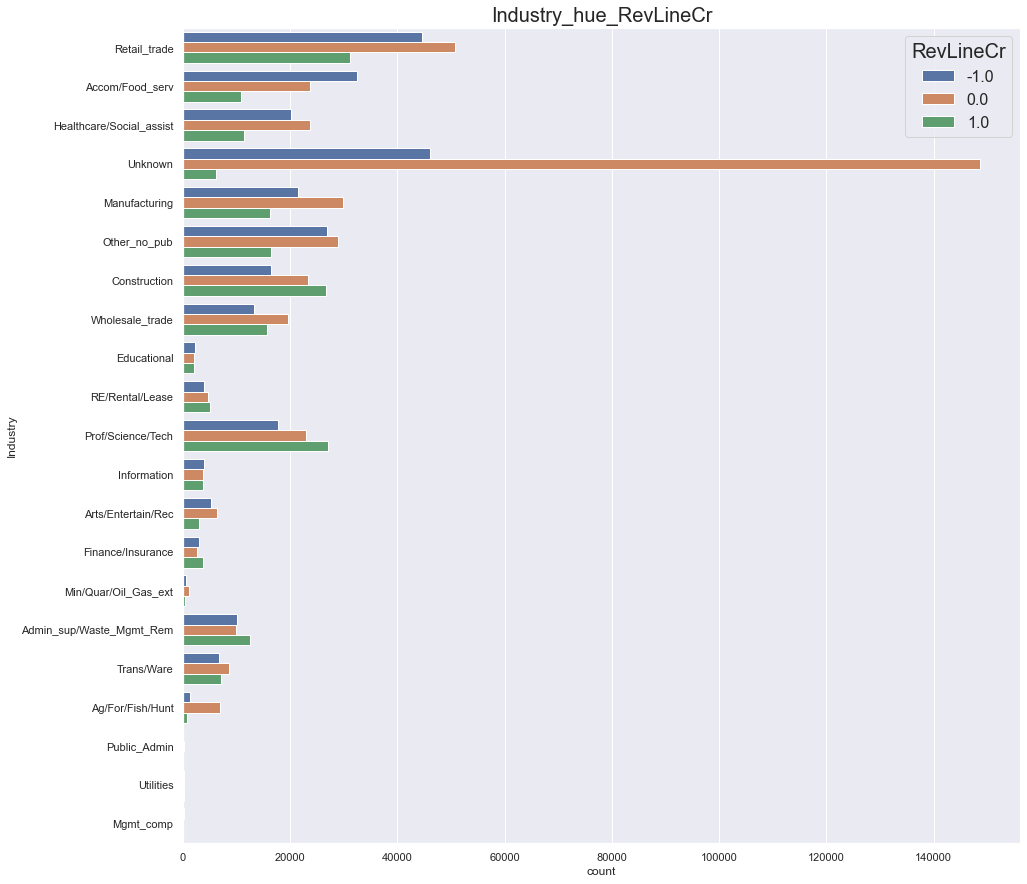

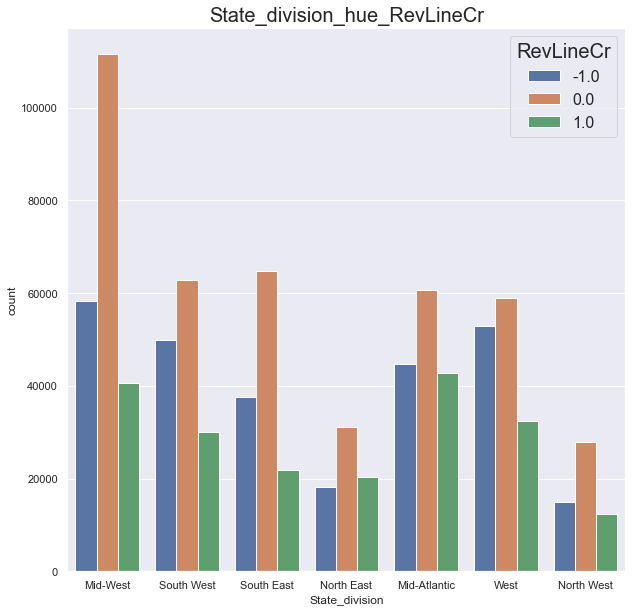

In [38]:
obj_visualization_with_hue(df_copy, obj_features, hue_col='RevLineCr')

# 2008~2014 State

In [39]:
df_0814 = df_copy[df_copy['DisbursementDate_year'] >= 2008]
df_pre08 = df_copy[df_copy['DisbursementDate_year'] < 2008]
# obj_visualization(df_0814, ['State', 'UrbanRural'])
# obj_visualization(df_pre08, ['State', 'UrbanRural'])

# Data Overview

In [40]:
display(df_copy.iloc[:3,:23])
display(df_copy.iloc[:3,23:])

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,ApprovalDate,Term,NoEmp,...,IsFranchised,UrbanRural,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,Default,ChgOffPrinGr
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,1997-02-28,84.0,4.0,...,0.0,-1,0.0,1.0,NaN,1999-02-28,90558.780300,0.0,0.0,NaN
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,1997-02-28,60.0,2.0,...,0.0,-1,0.0,1.0,NaN,1997-05-31,60372.520200,0.0,0.0,NaN
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,1997-02-28,180.0,7.0,...,0.0,-1,0.0,0.0,NaN,1997-12-31,433172.832435,0.0,0.0,NaN


,GrAppv,SBA_Appv,Industry,ChgOffDate_year,ChgOffDate_month,ChgOffDate_day,DisbursementDate_year,DisbursementDate_month,DisbursementDate_day,ApprovalDate_year,...,Population,PopDensity,HousingUnits,OccupiedHousingUnits,MedianHomeValue,MedianHouseholdIncome,DisbursePerEmployee,GrSBA_AppvDiff%,State_division,USDPerJobCreated
0,90558.780300,72447.024240,Retail_trade,NaN,NaN,NaN,1999.0,2.0,28.0,1997.0,...,31457.0,1939.0,14267.0,12895.0,115600.0,48618.0,12000.000000,20.0,Mid-West,NaN
1,60372.520200,48298.016160,Accom/Food_serv,NaN,NaN,NaN,1997.0,5.0,31.0,1997.0,...,30671.0,457.0,11847.0,10938.0,120200.0,47863.0,13333.333333,20.0,Mid-West,NaN
2,433172.832435,324879.624326,Healthcare/Social_assist,NaN,NaN,NaN,1997.0,12.0,31.0,1997.0,...,41011.0,495.0,19124.0,17562.0,207900.0,45415.0,35875.000000,25.0,Mid-West,NaN


In [41]:
df_copy.to_csv('clean5.csv', index=False)